In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
from scipy.optimize import minimize
from scipy.stats.mstats import winsorize
from scipy.stats import expon
from scipy.stats import pareto
from scipy.stats import lognorm
from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
data = pd.read_stata('C:\\Users\\chans\\Desktop\\UpdatedEmpirics\\projects_MLE.dta')

In [3]:
data.info(), data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1324126 entries, 0 to 1324125
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   year               1324126 non-null  float64
 1   recipient          1324126 non-null  object 
 2   loan               1324126 non-null  float32
 3   donor_group        1324126 non-null  float32
 4   commitment_conusd  1317442 non-null  float32
 5   iso_code           1324126 non-null  object 
 6   sector             1324126 non-null  object 
dtypes: float32(3), float64(1), object(3)
memory usage: 65.7+ MB


(None,
      year    recipient  loan  donor_group  commitment_conusd iso_code  \
 0  2000.0  Afghanistan   0.0          1.0       2.384015e+06      AFG   
 1  2000.0  Afghanistan   0.0          1.0       2.228849e+04      AFG   
 2  2000.0  Afghanistan   0.0          1.0       2.441563e+04      AFG   
 3  2000.0  Afghanistan   0.0          1.0       1.661612e+04      AFG   
 4  2000.0  Afghanistan   0.0          1.0       5.791217e+04      AFG   
 
       sector  
 0     Health  
 1     Health  
 2     Health  
 3  Education  
 4  Education  )

In [4]:
clean_data = data[np.isfinite(data['commitment_conusd'])]

In [5]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1317442 entries, 0 to 1324125
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   year               1317442 non-null  float64
 1   recipient          1317442 non-null  object 
 2   loan               1317442 non-null  float32
 3   donor_group        1317442 non-null  float32
 4   commitment_conusd  1317442 non-null  float32
 5   iso_code           1317442 non-null  object 
 6   sector             1317442 non-null  object 
dtypes: float32(3), float64(1), object(3)
memory usage: 65.3+ MB


In [6]:
def estimate_pareto_params_mle(data):
    params = stats.pareto.fit(data, floc=0)
    alpha, loc, xm = params
    return alpha, xm

In [7]:
def estimate_pareto_right_tail_with_gof(data):
    # Sort the data in descending order
    data_sorted = np.sort(data)[::-1]
    n = len(data_sorted)
    
    percentile = 1
    top_data = data_sorted[:int(n * percentile / 100)]
    
    if len(top_data) < 30:
        return None, None, None, None, None, None
    
    alpha, xm = estimate_pareto_params_mle(top_data)
    D, p_value = stats.kstest(top_data, 'pareto', args=(alpha, 0, xm))
    
    #if alpha > 1 and p_value > 0.05:
    return alpha, xm, percentile, len(top_data), D, p_value
    

In [8]:
def combined_plot(data, alpha, xm, title, num_observations, ks_stat, p_value, percentile):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Q-Q Plot
    stats.probplot(data, dist="pareto", sparams=(alpha, 0, xm), plot=ax1)
    ax1.set_title(f"Q-Q Plot ({title})")
    ax1.set_xlabel('Theoretical quantiles')
    ax1.set_ylabel('Empirical quantiles')
    
    # Histogram with fitted Pareto density
    ax2.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Empirical Data')
    x = np.linspace(data.min(), data.max(), 1000)
    pdf = alpha * xm**alpha / x**(alpha + 1)
    ax2.plot(x, pdf, 'r-', lw=2, label='Fitted Pareto PDF')
    ax2.set_title(f"Fitted Density ({title})")
    ax2.set_xlabel('Commitment (constant USD)')
    ax2.set_ylabel('Density')
    ax2.legend()
    
    # Add annotations
    textstr = '\n'.join((
        f'Number of observations: {num_observations}',
        f'Estimated ξ/σ: {alpha:.2f}',
        f'Kolmogorov-Smirnov statistic: {ks_stat:.2f}',
        f'p-value: {p_value:.2f}',
        f'Sample: top {percentile}%'
    ))
    
    # Place text box in top left corner
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()



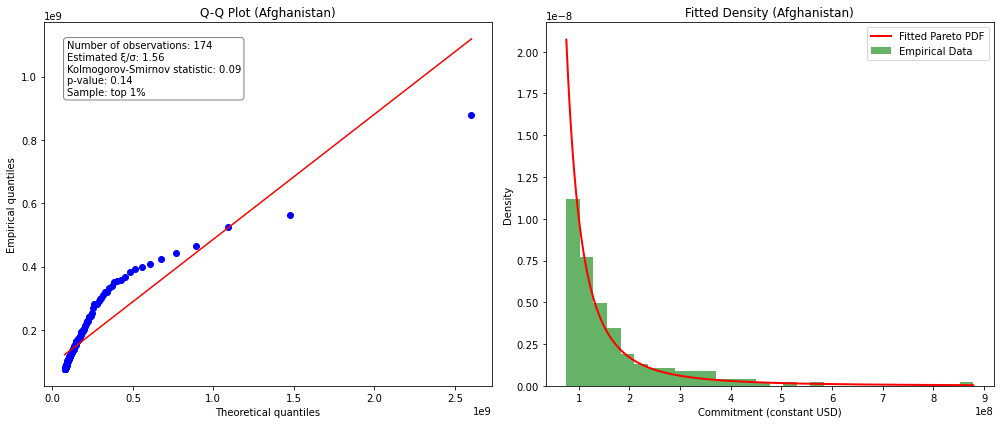

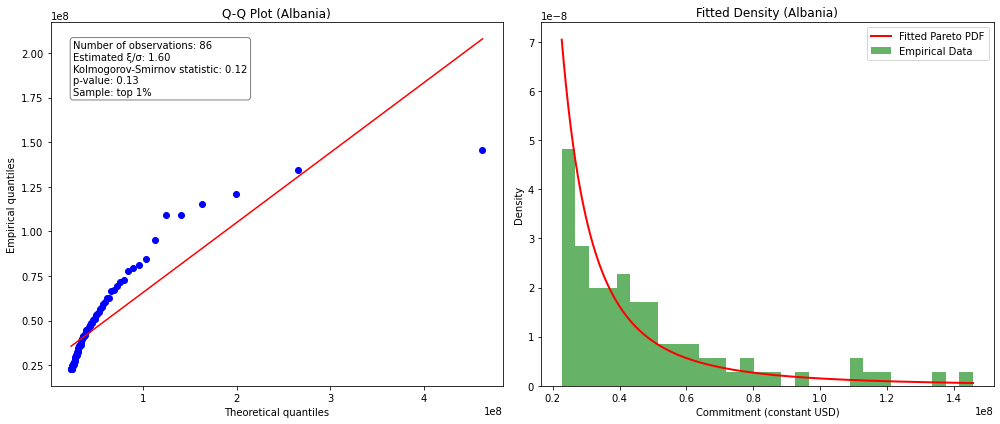

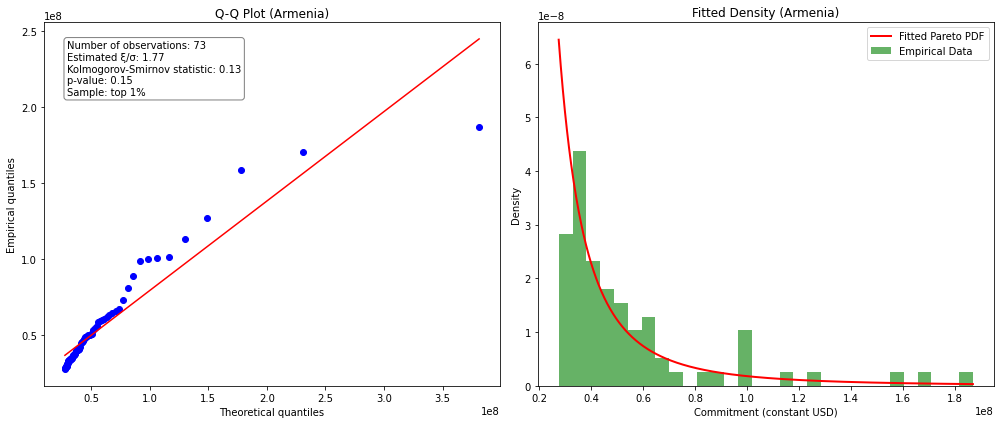

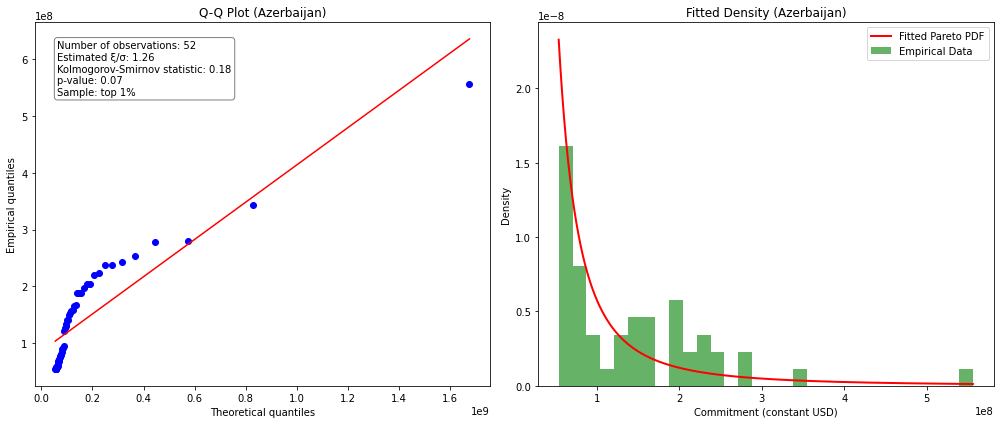

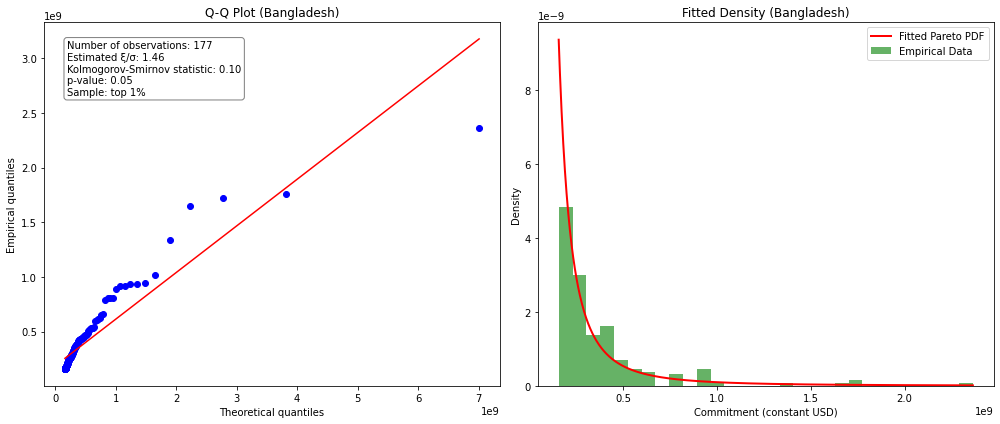

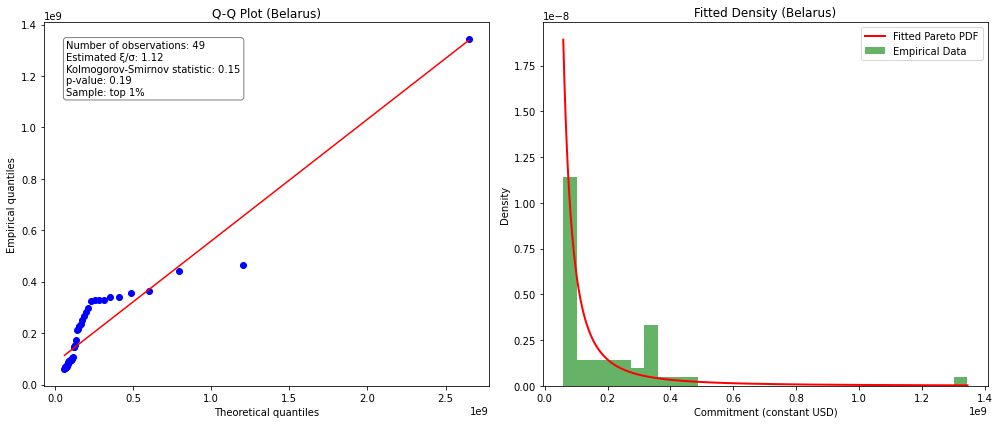

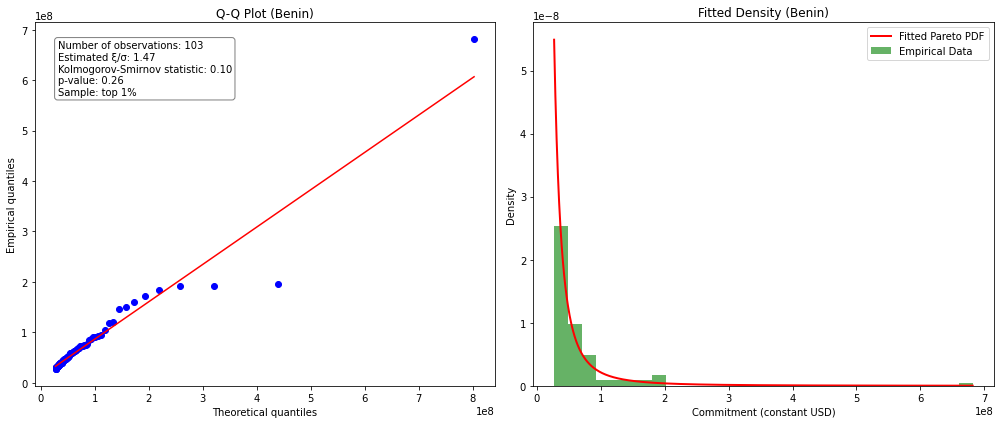

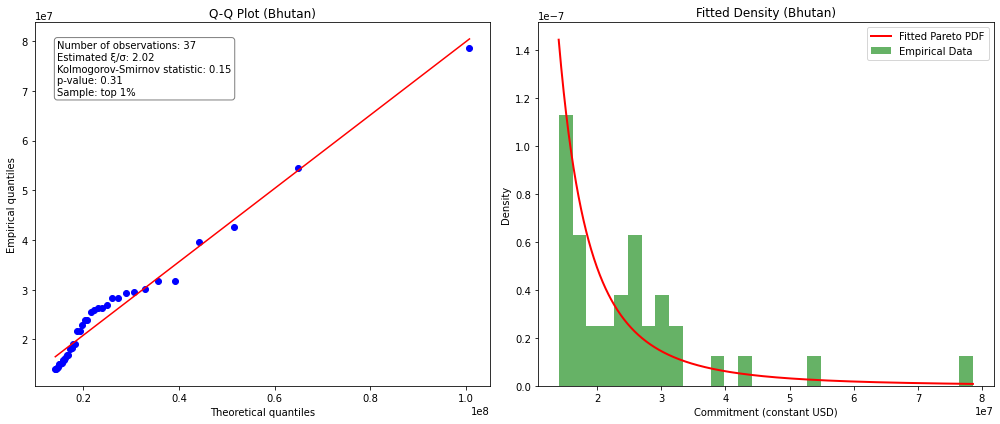

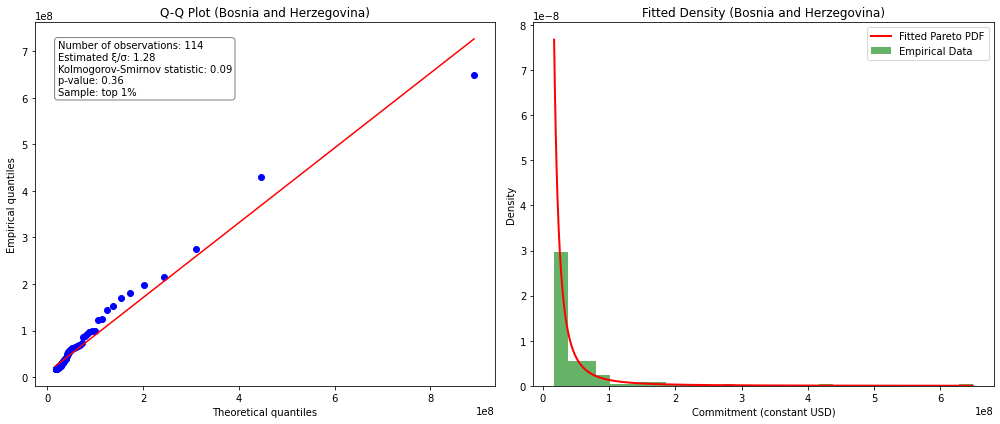

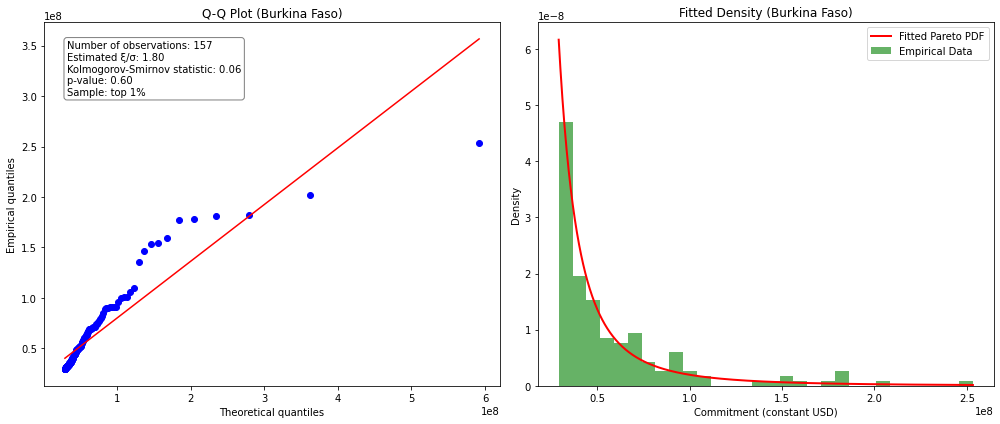

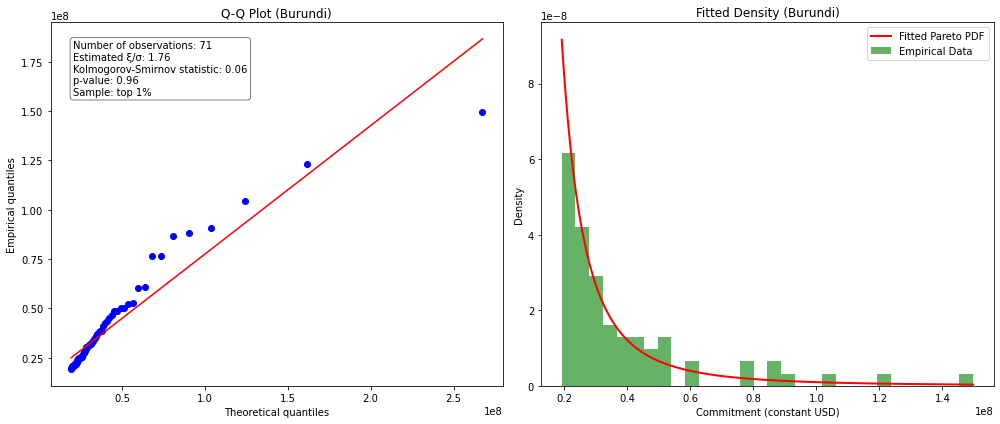

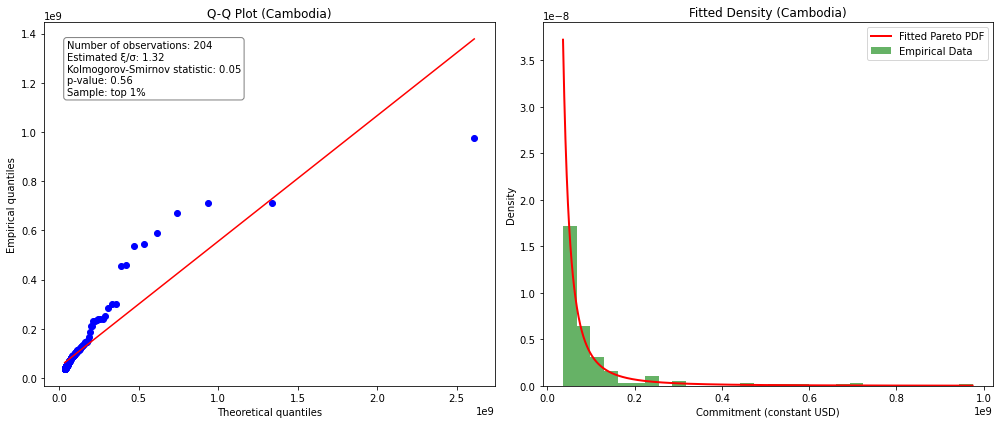

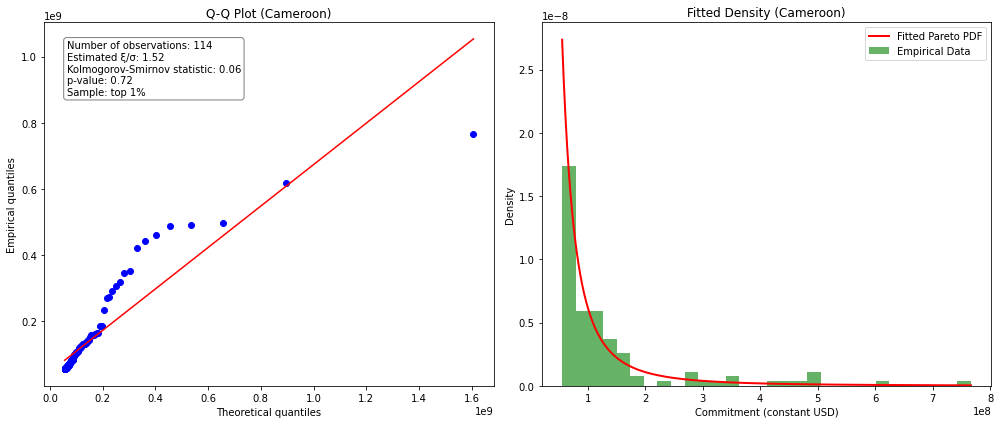

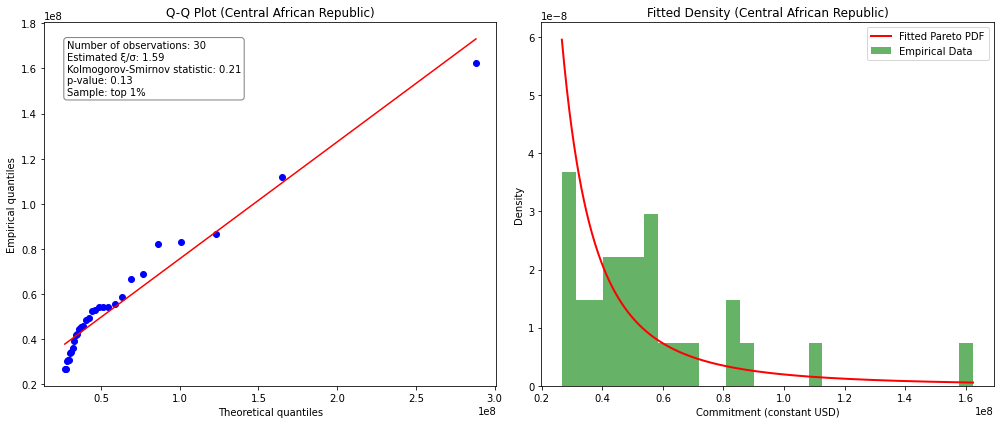

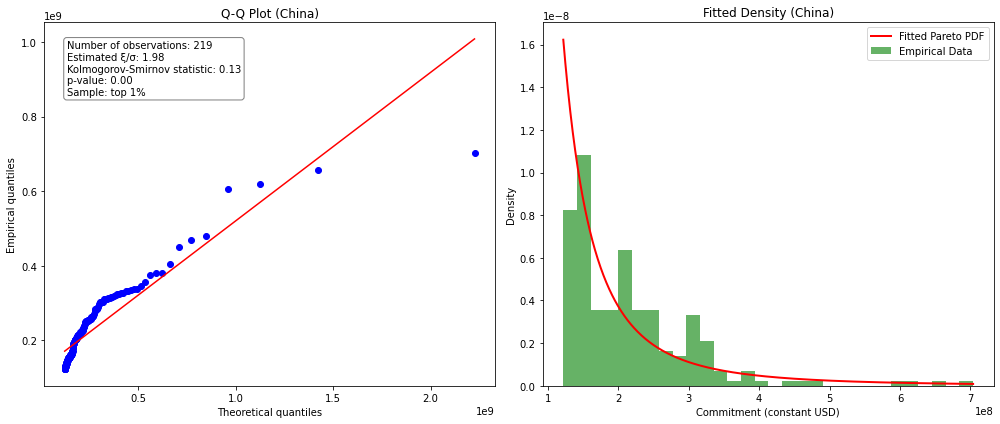

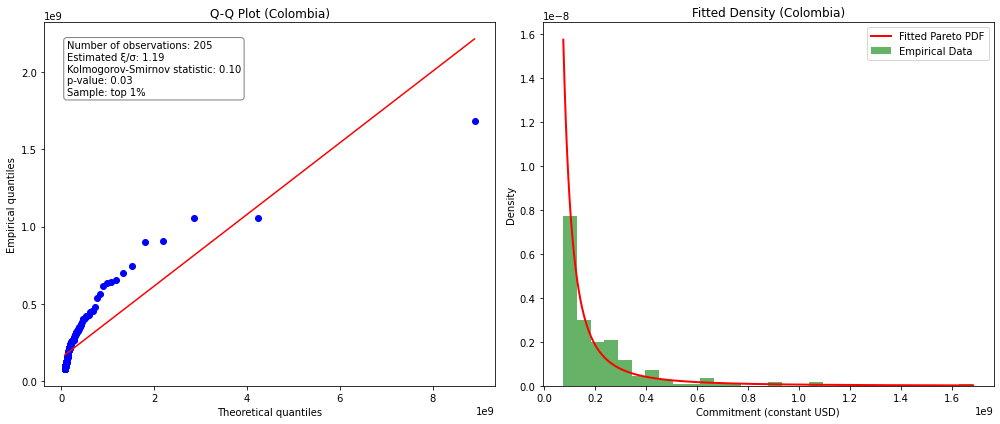

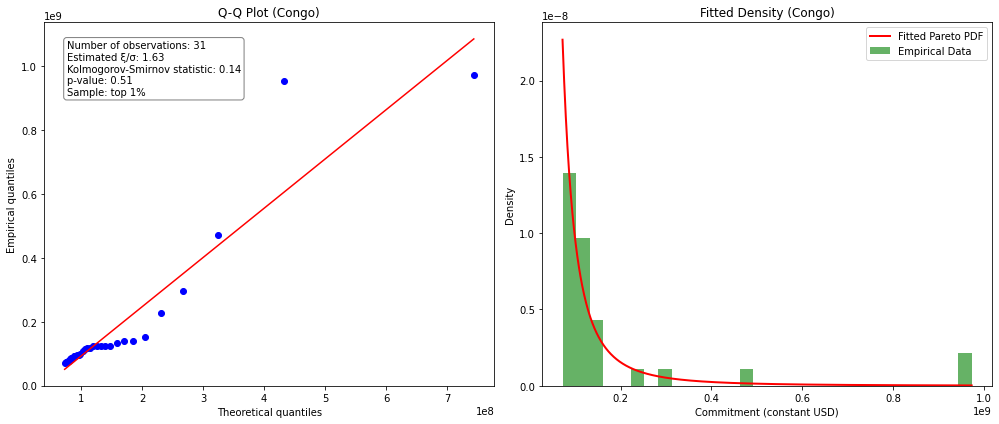

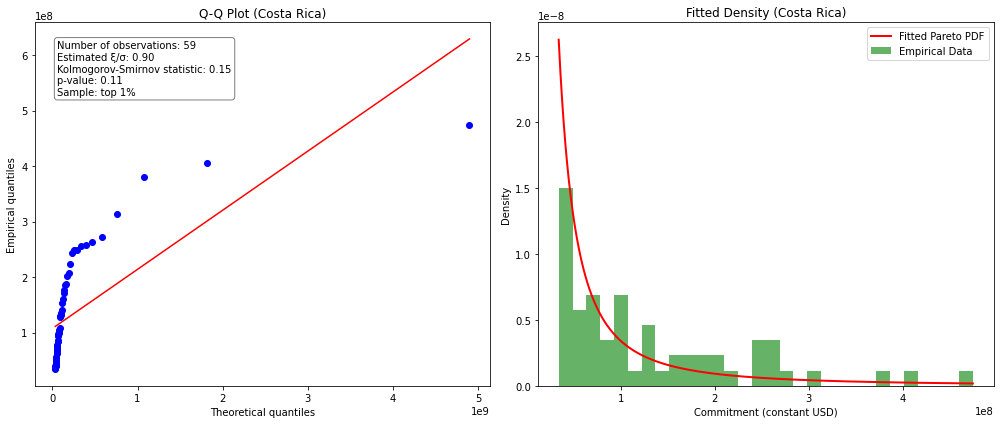

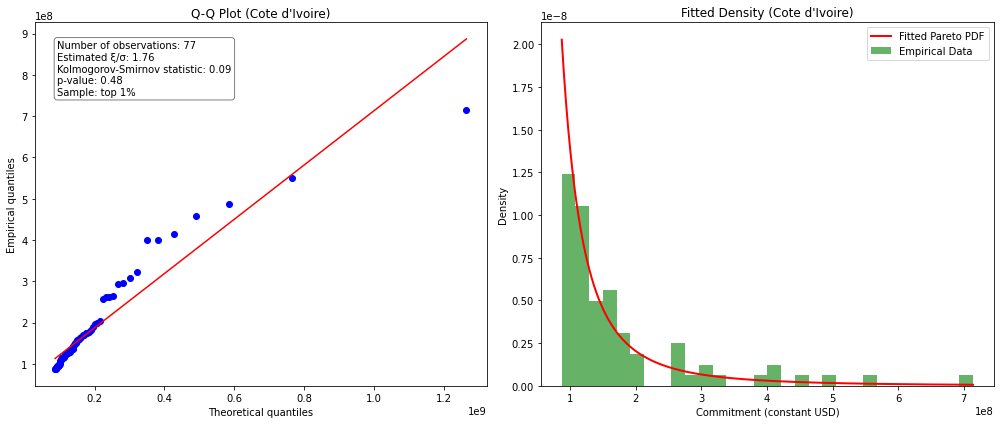

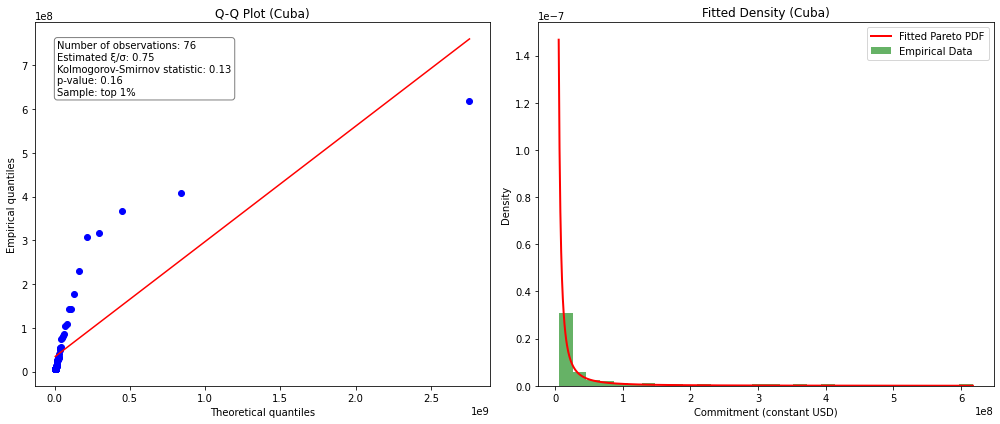

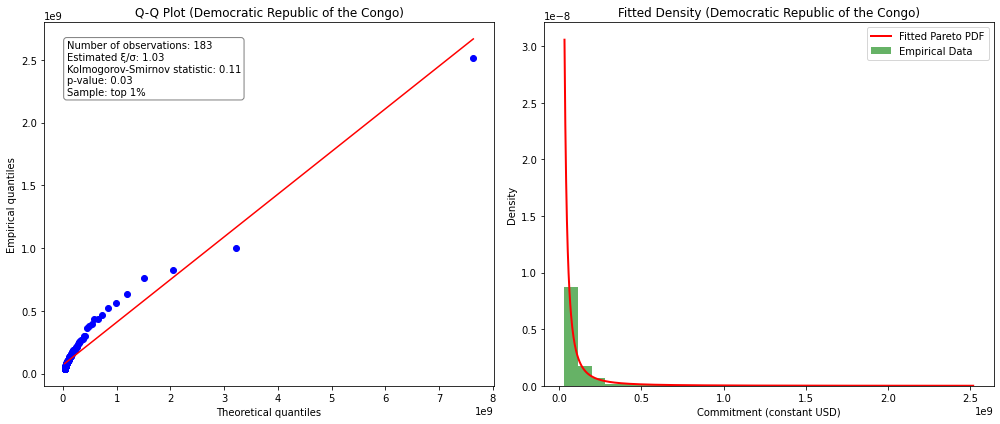

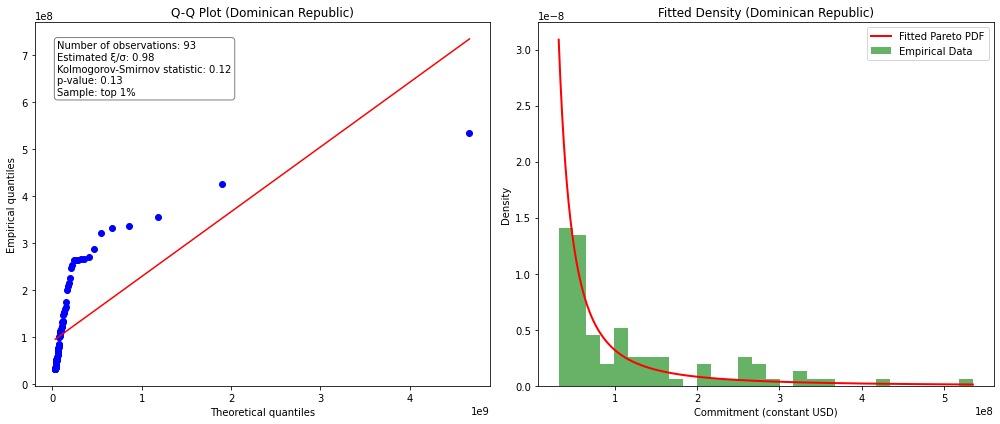

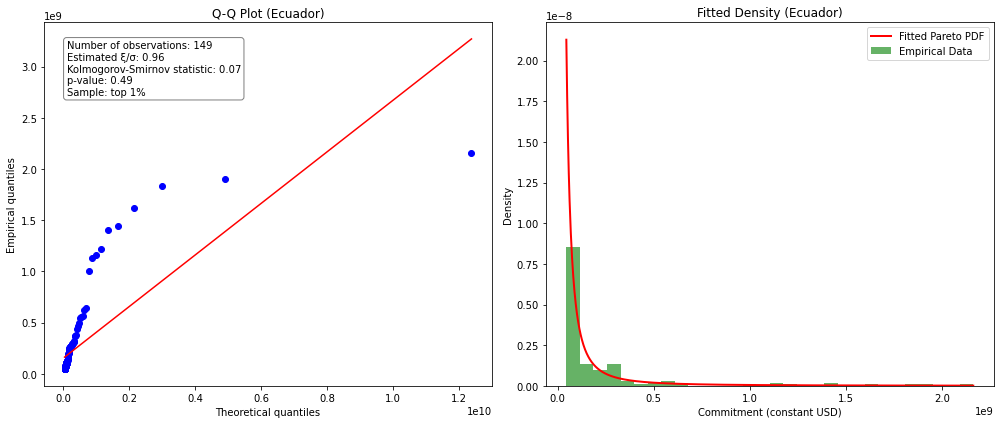

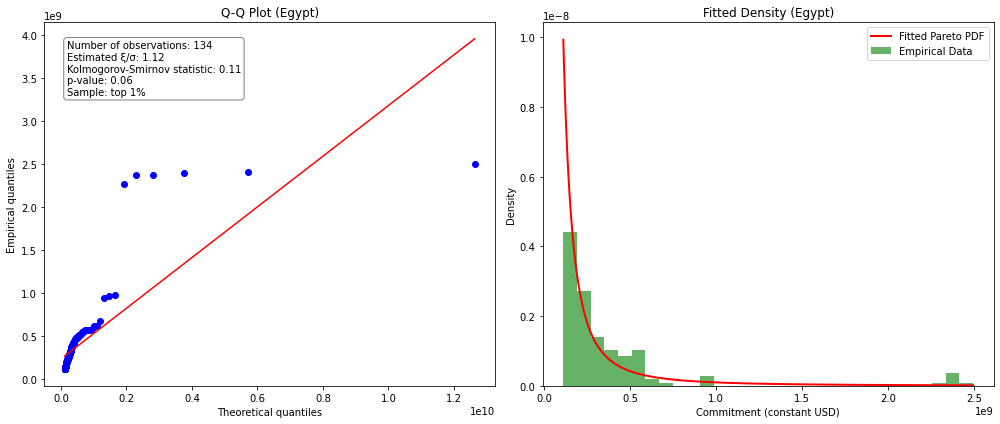

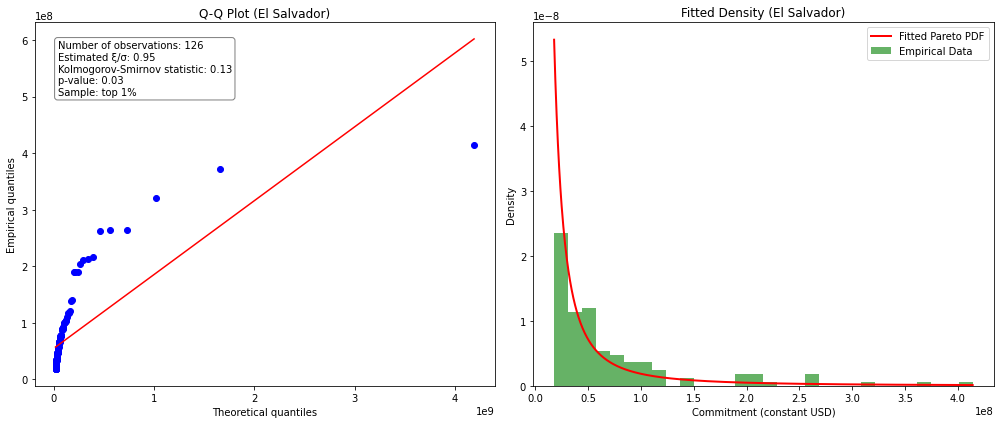

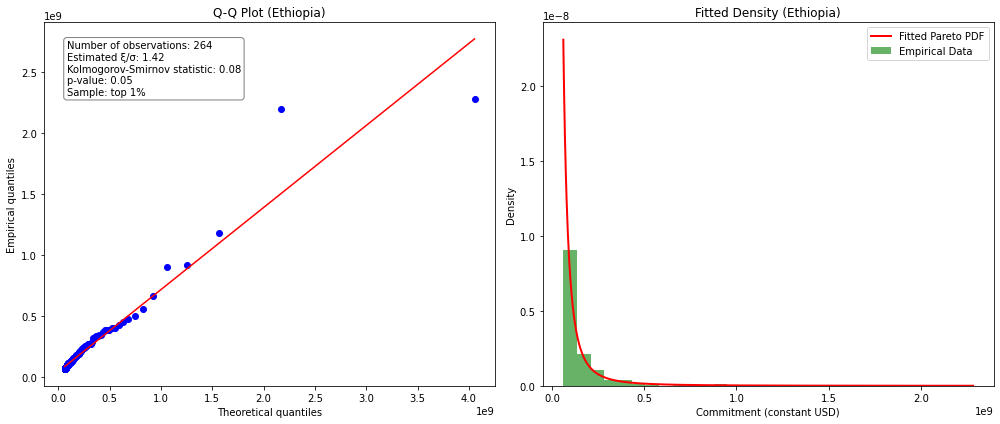

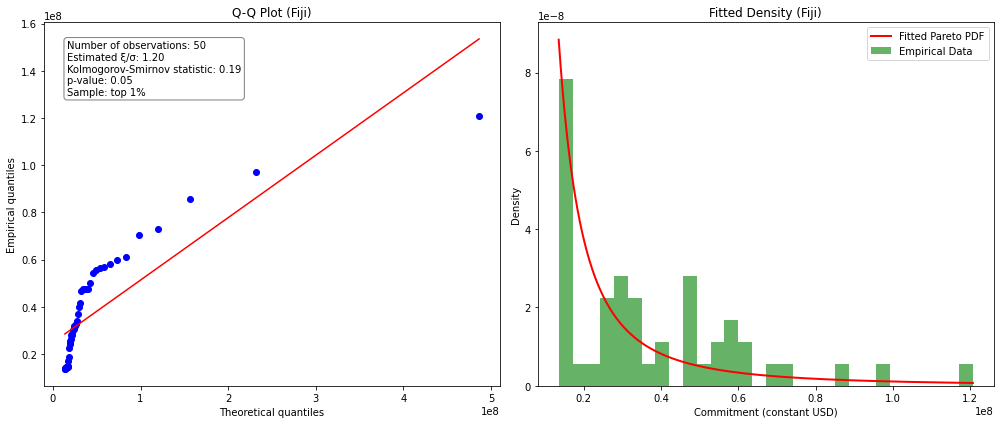

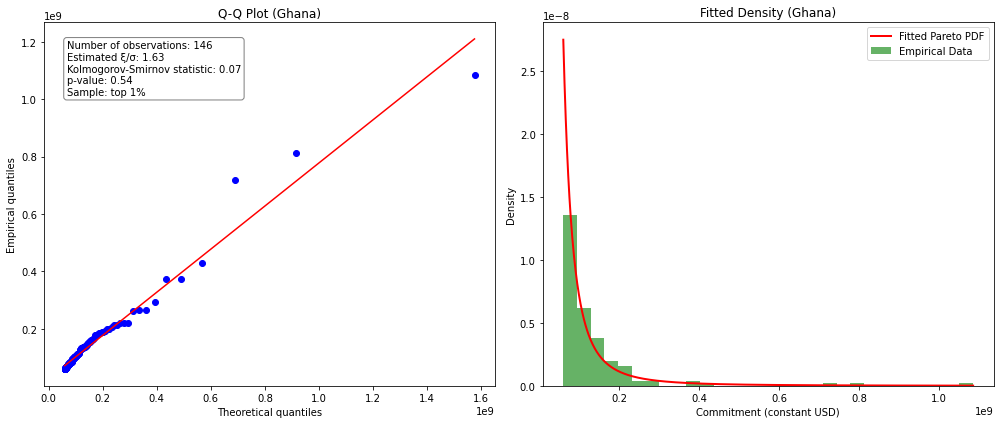

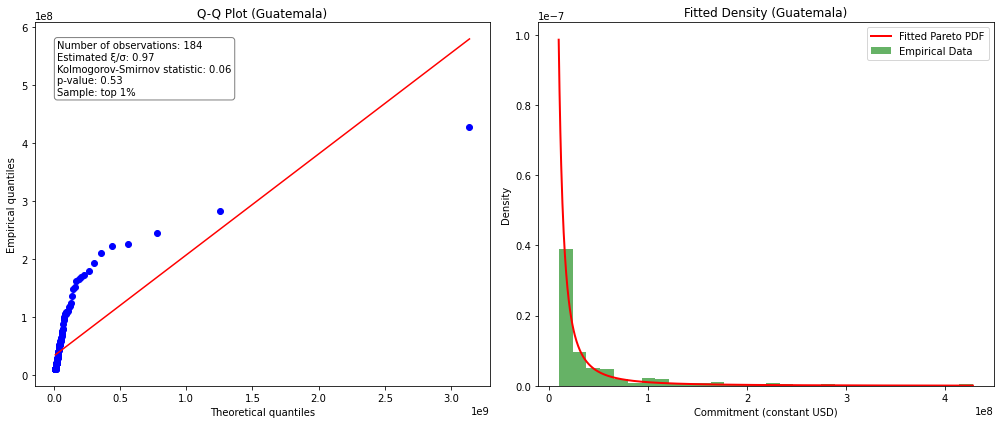

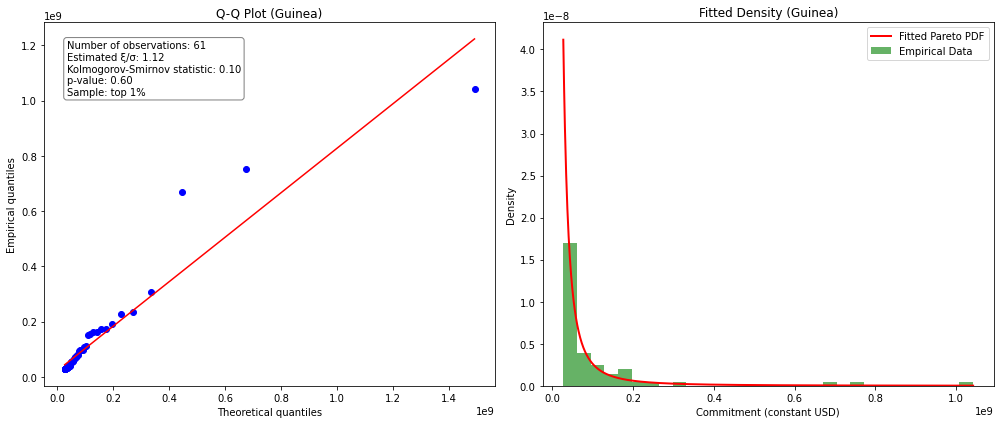

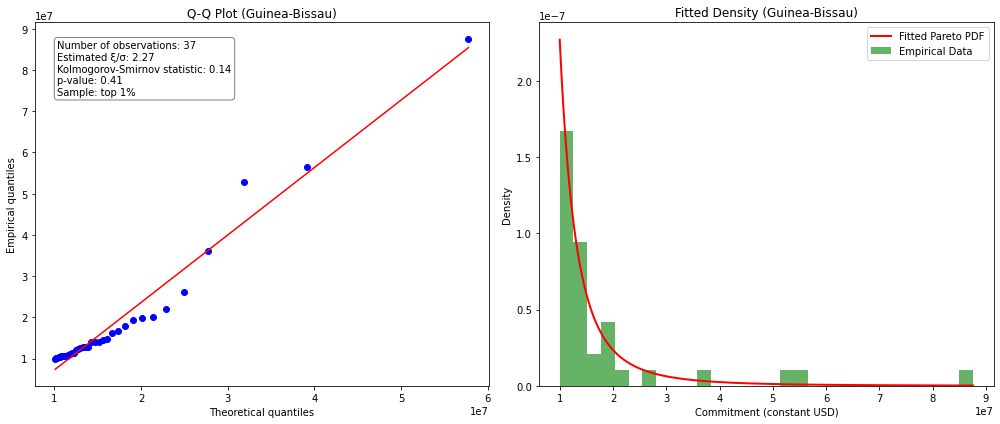

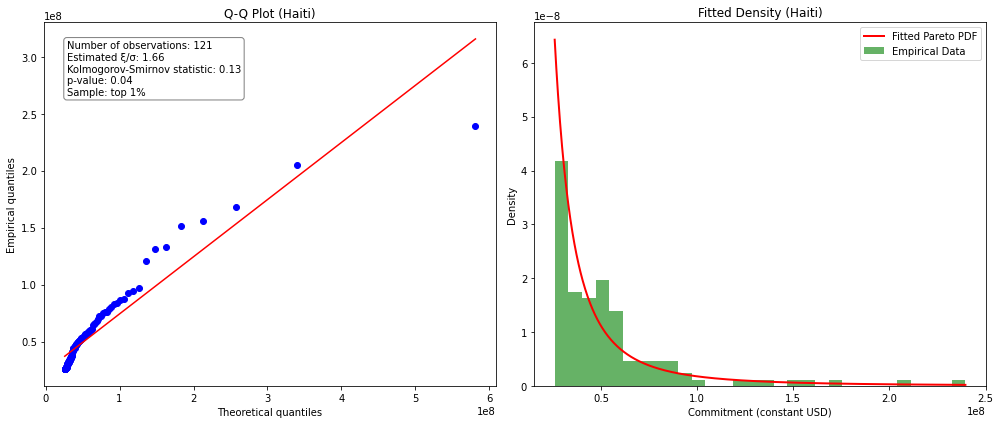

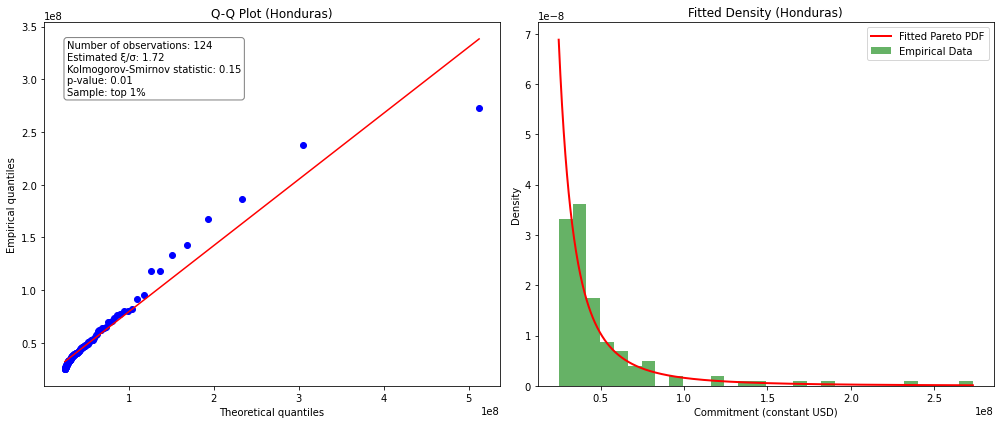

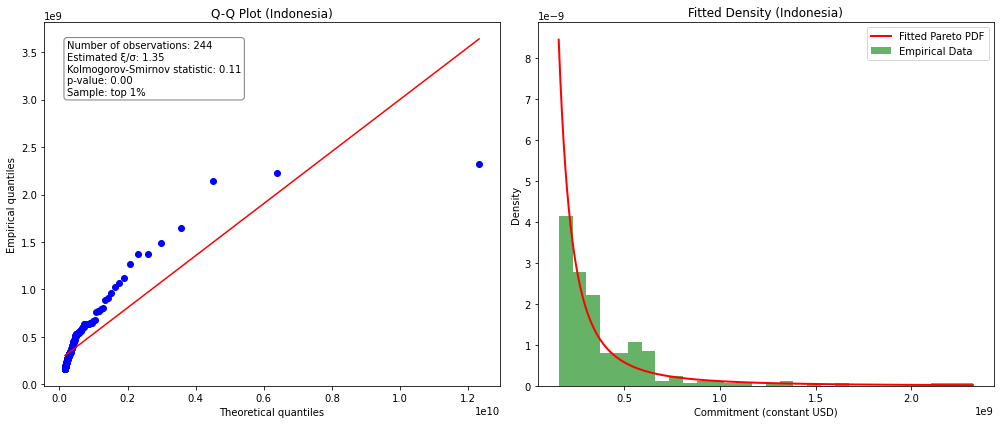

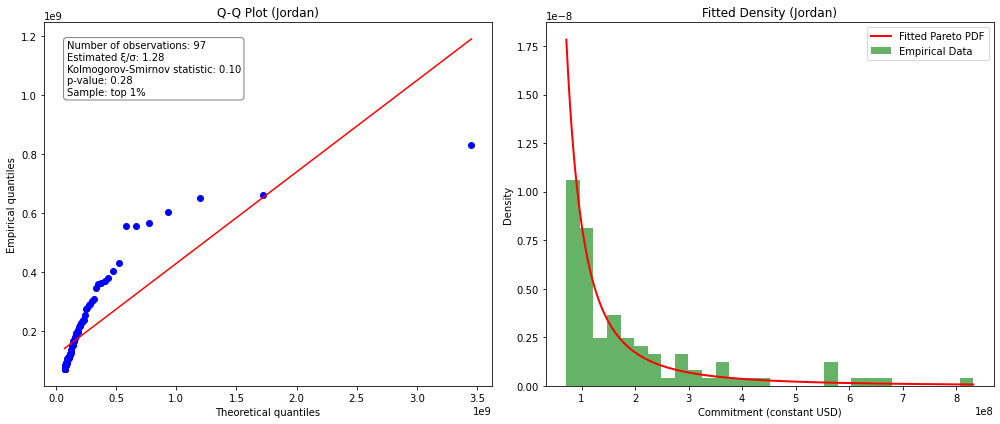

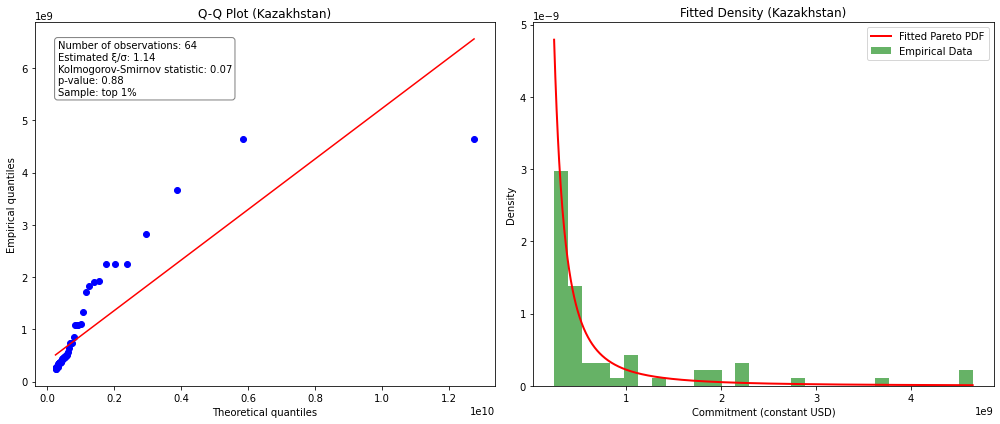

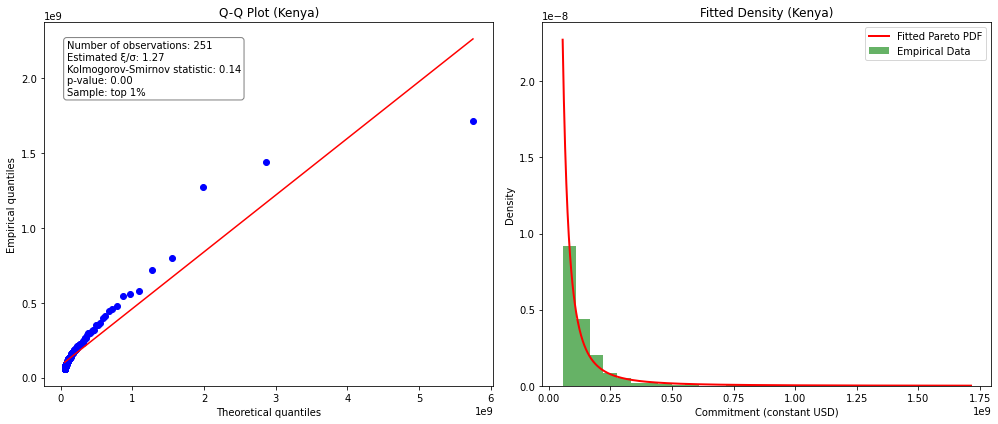

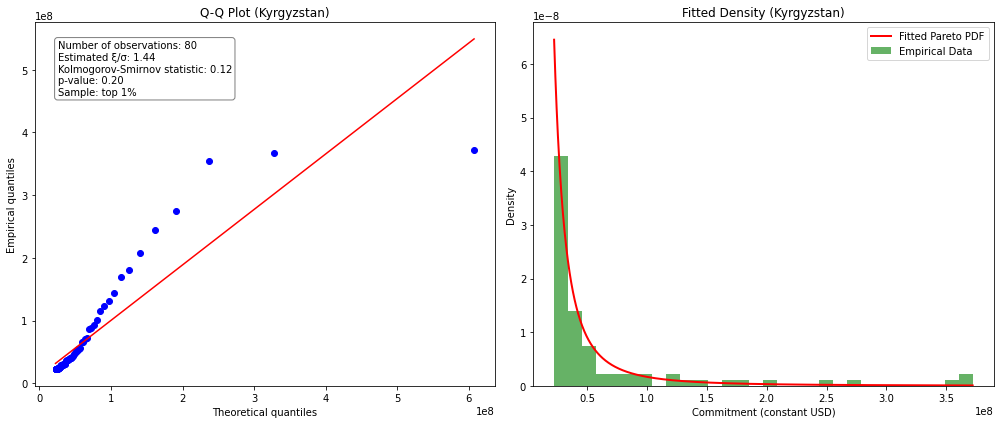

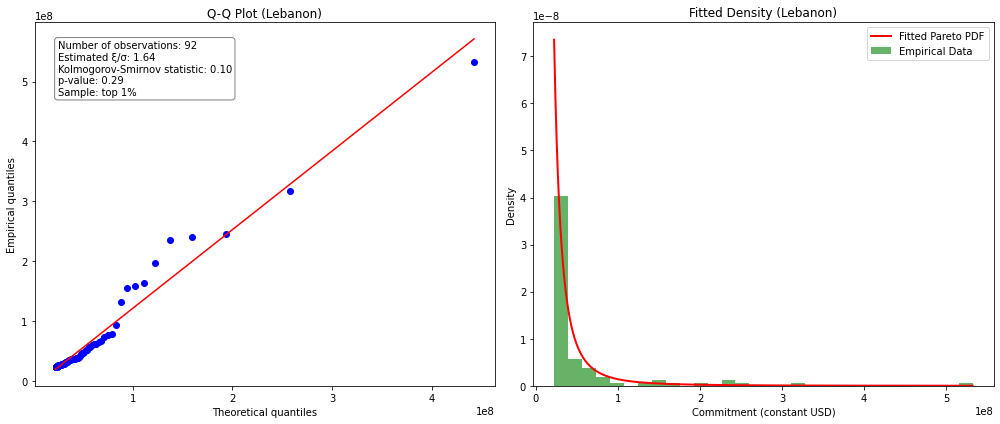

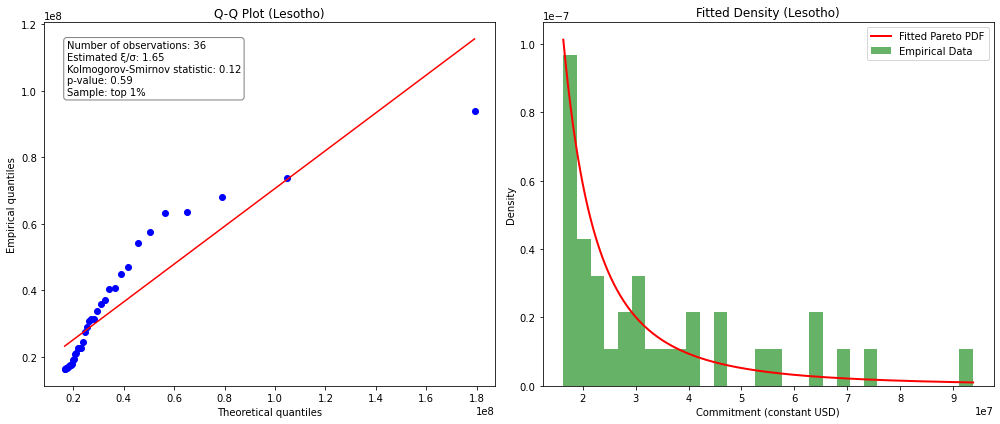

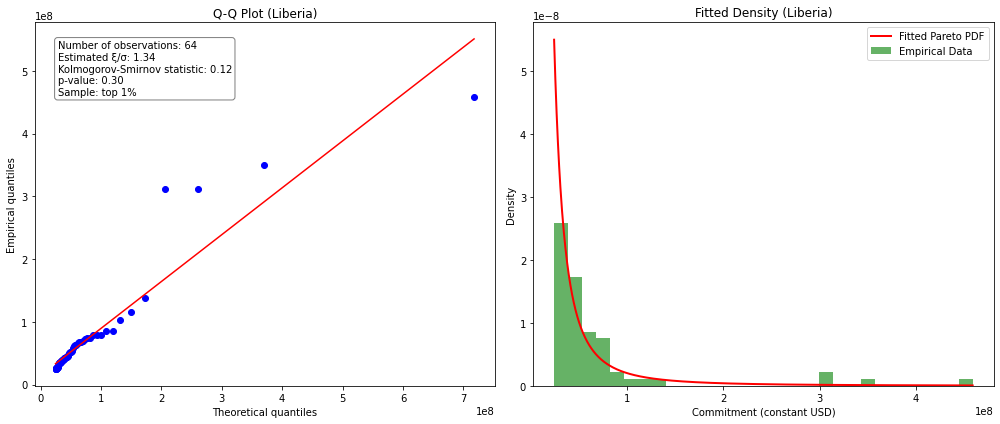

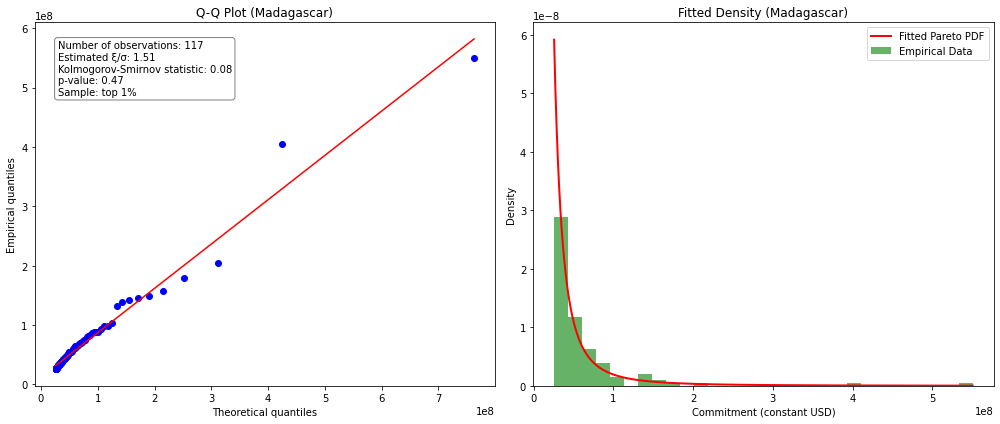

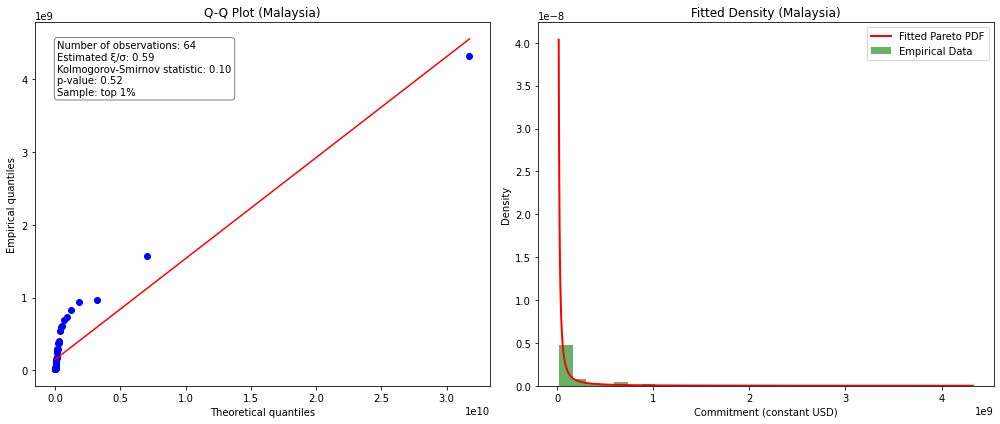

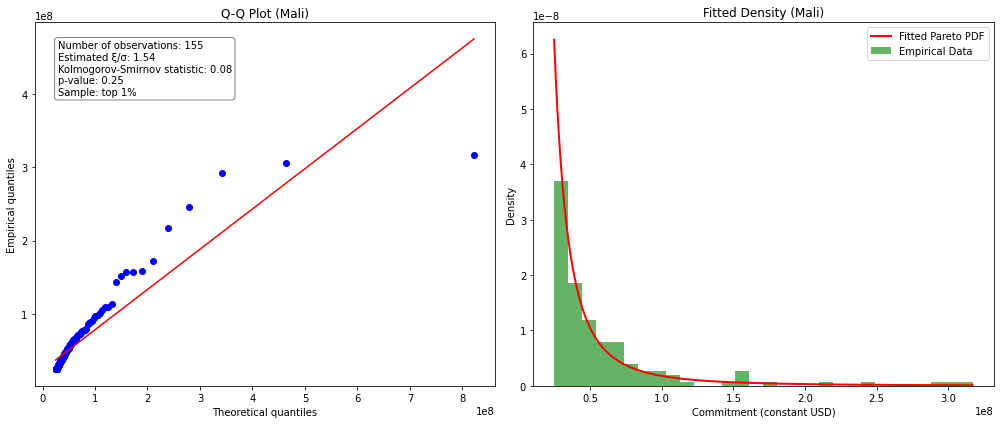

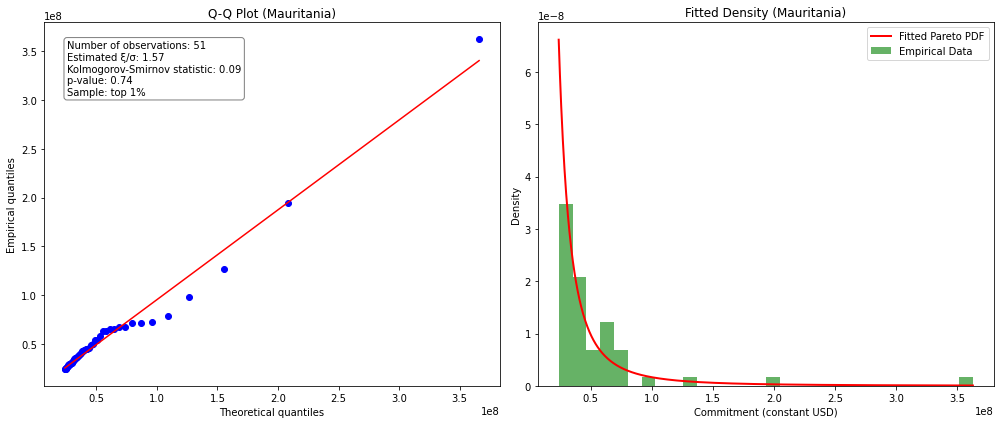

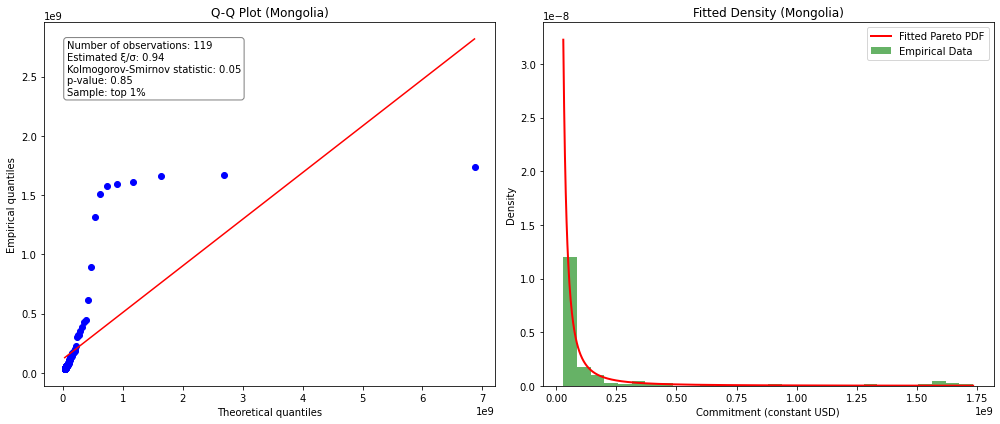

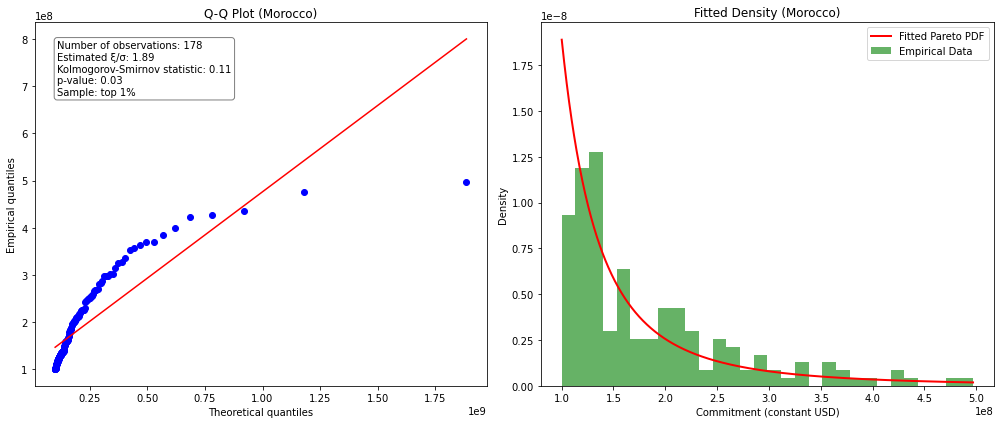

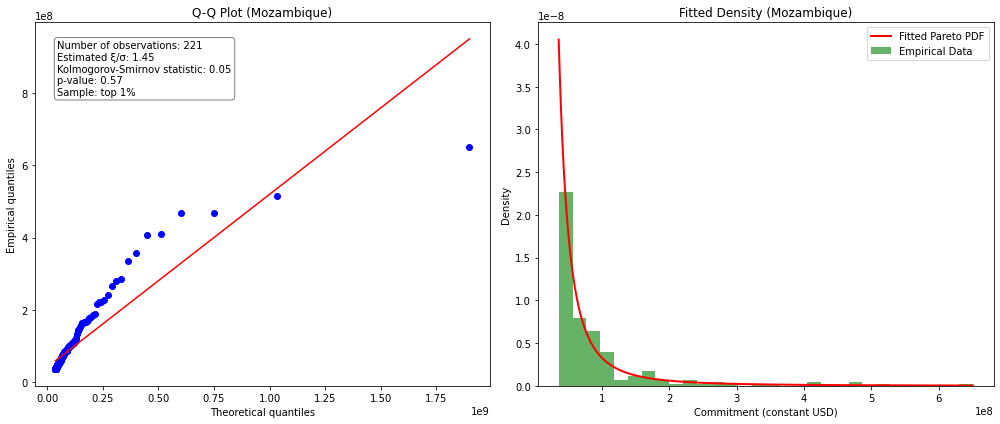

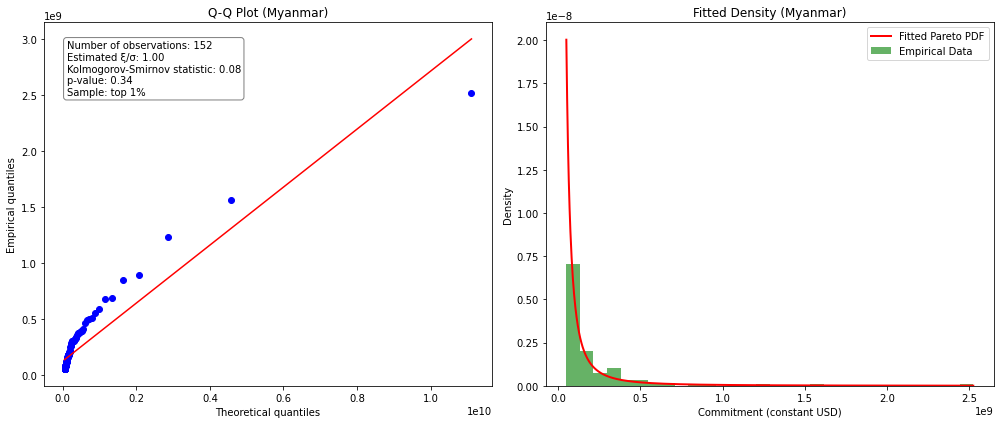

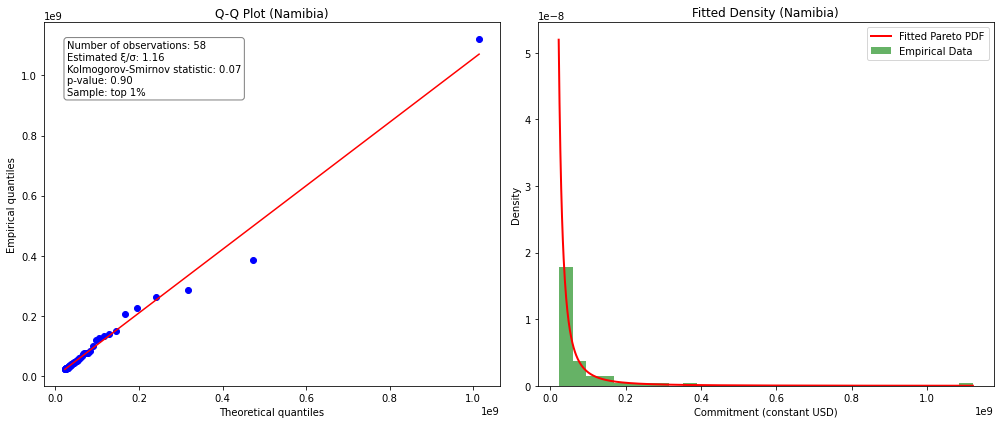

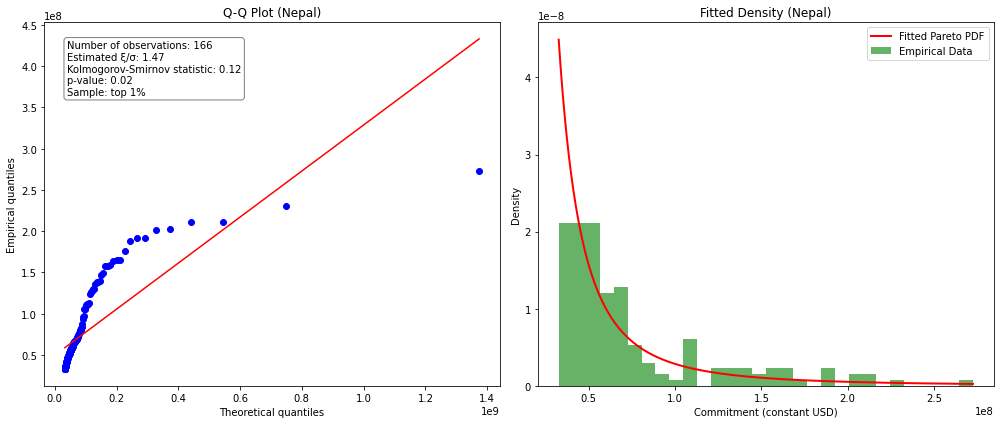

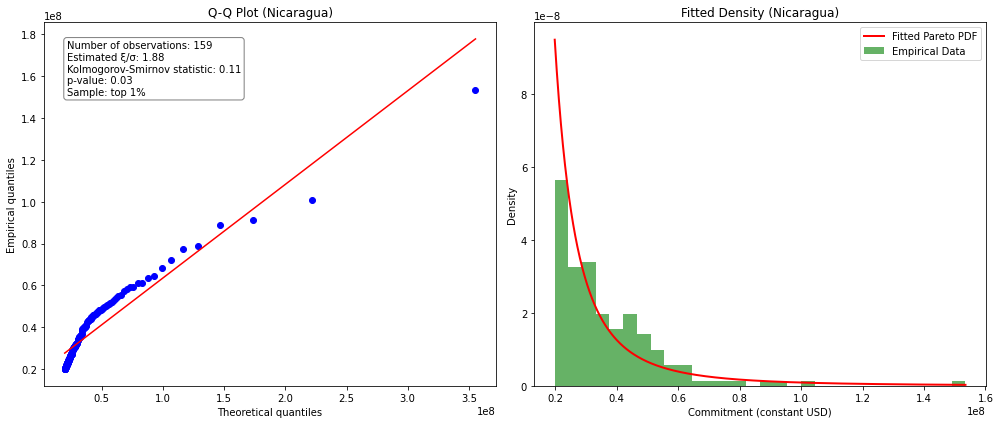

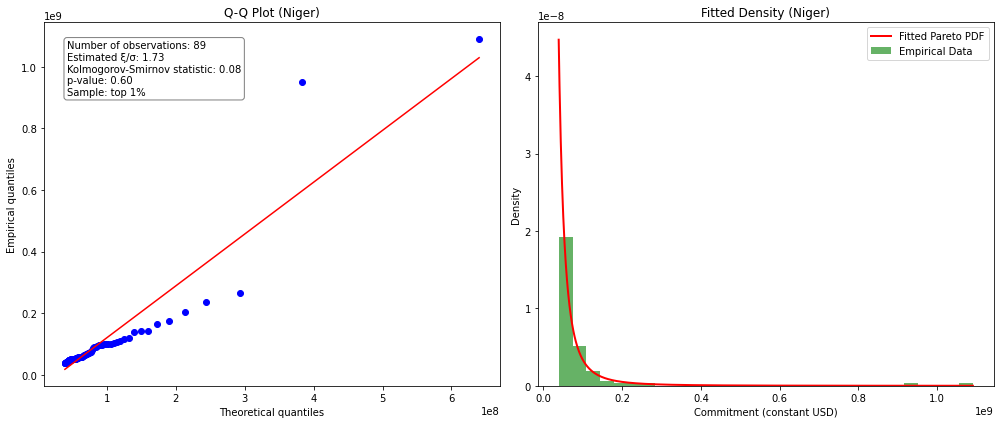

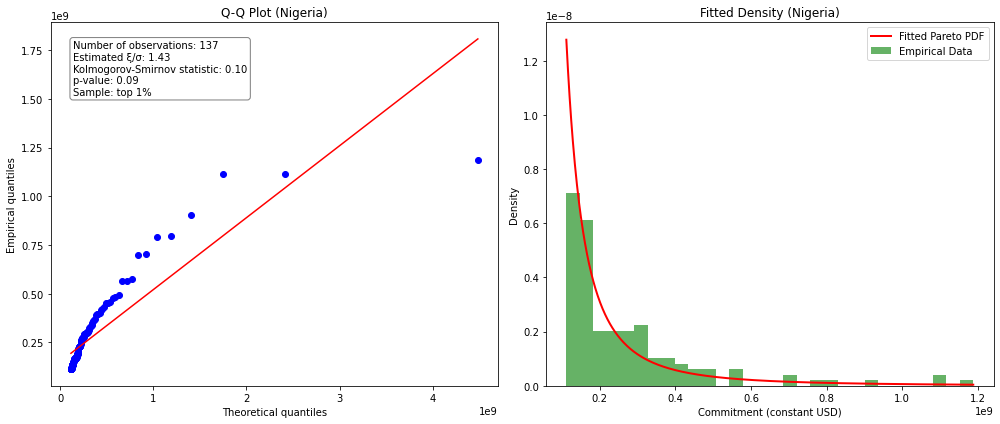

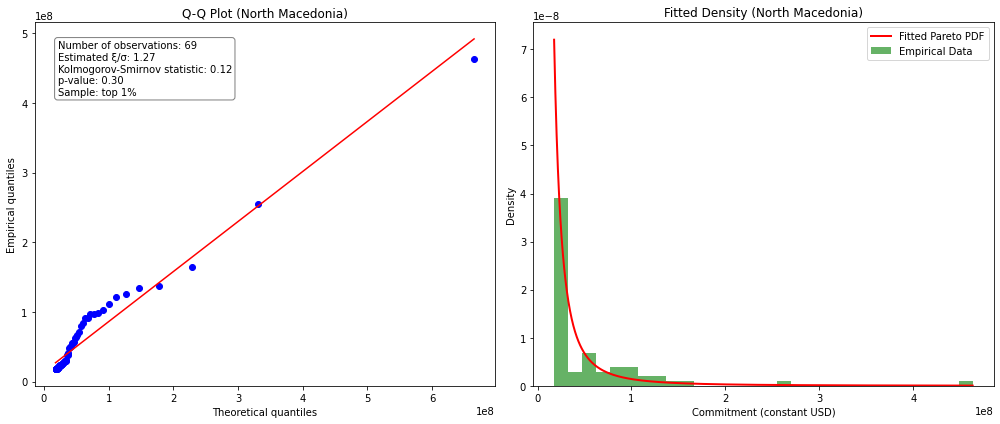

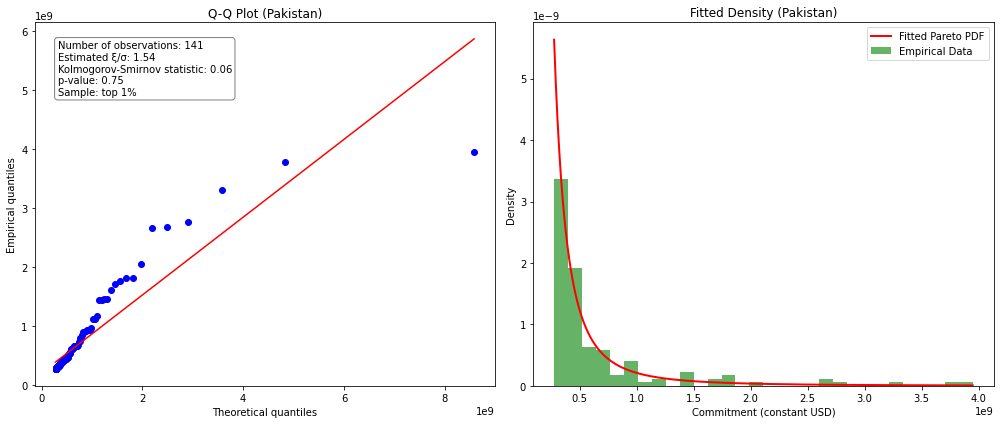

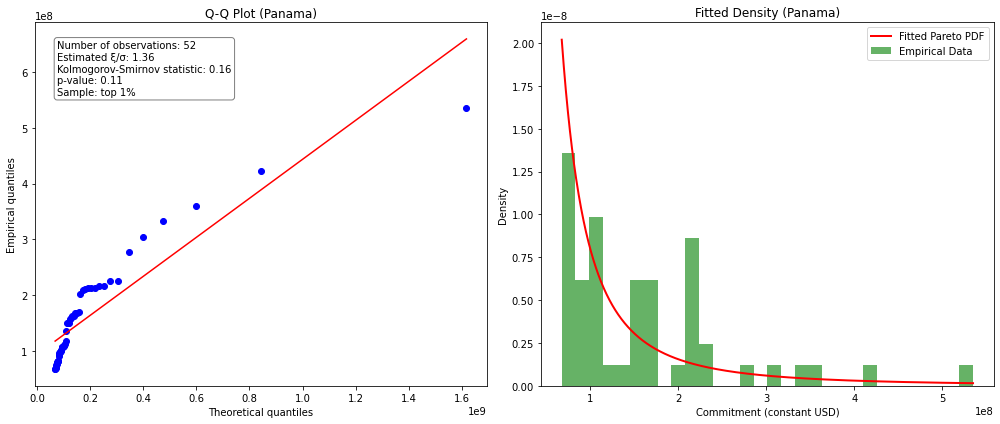

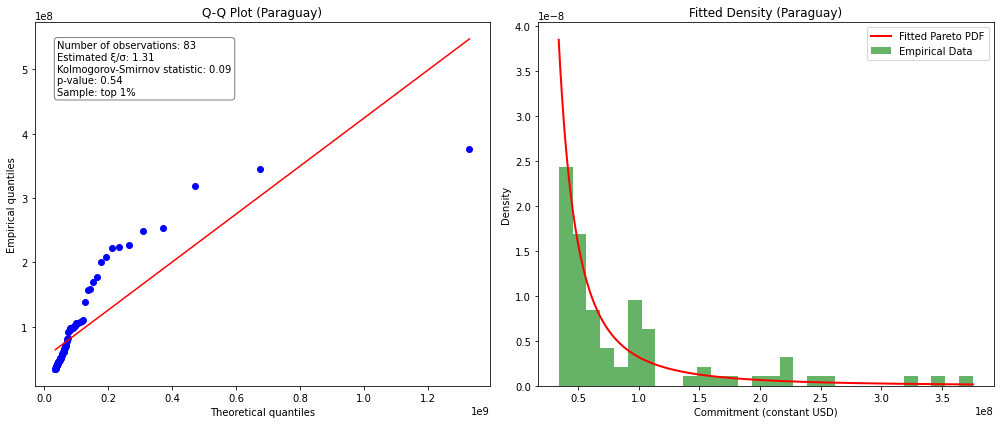

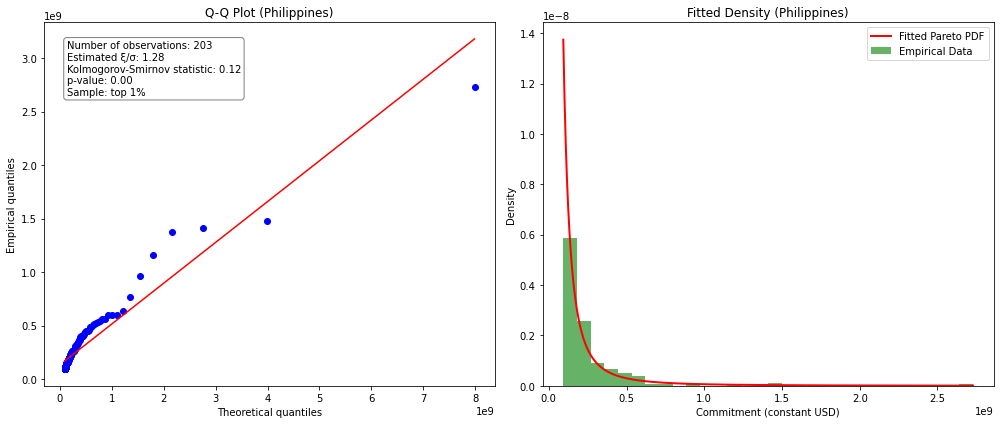

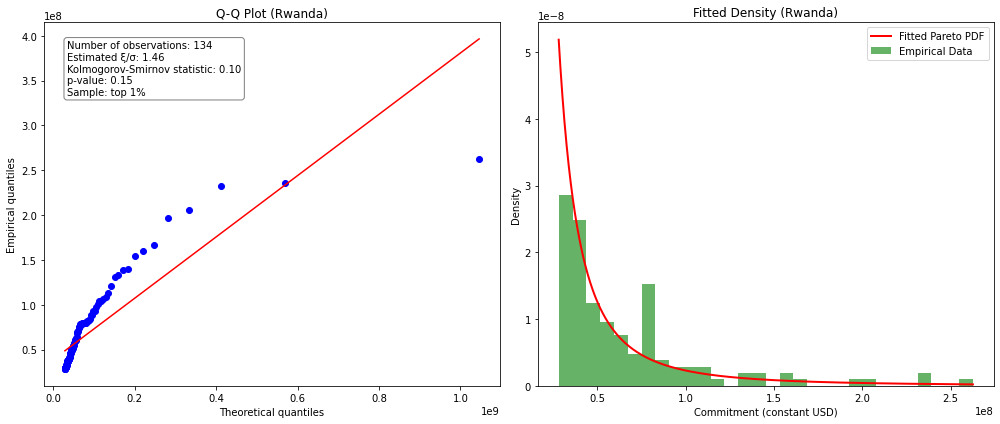

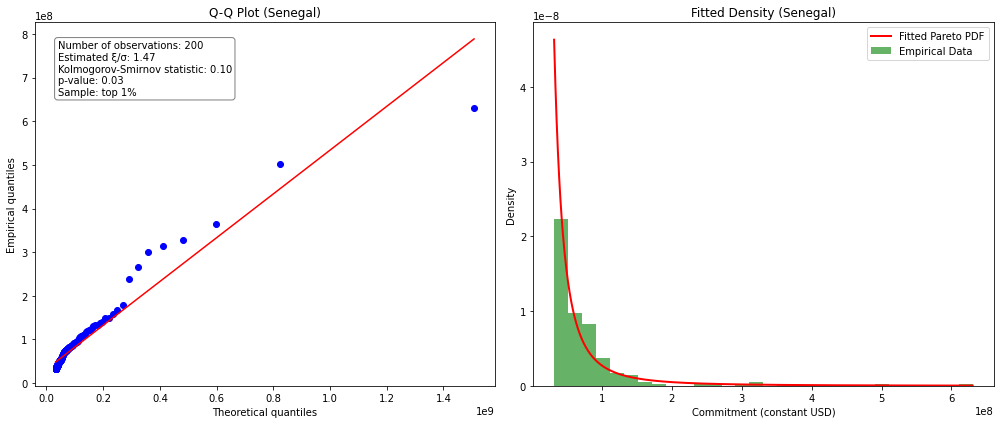

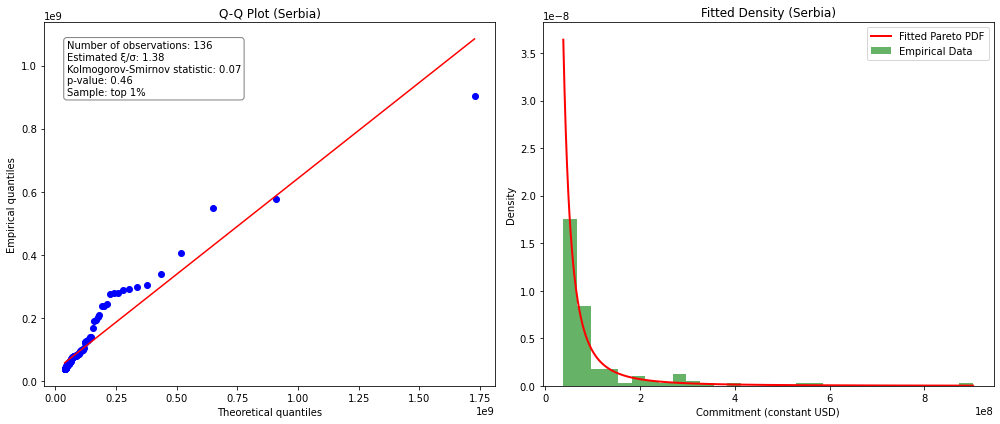

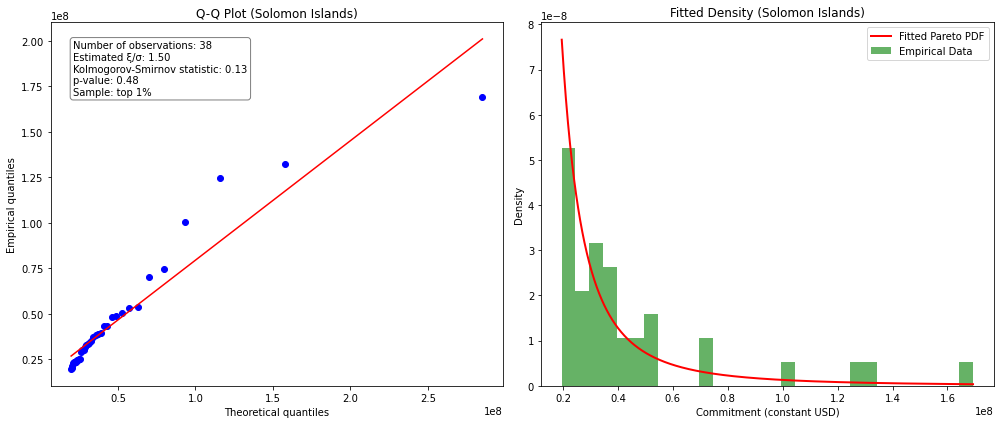

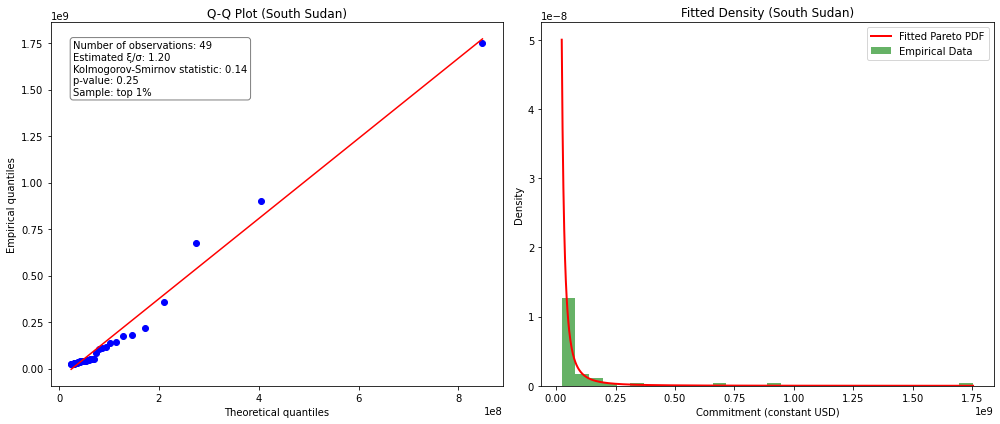

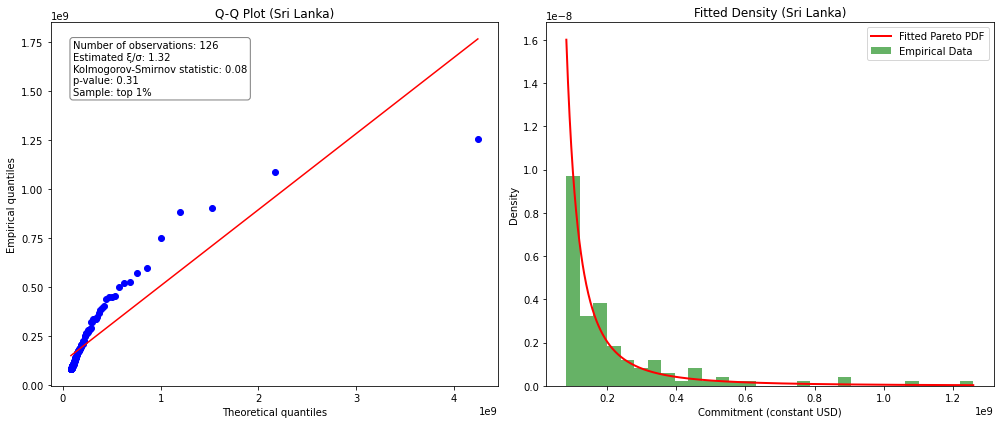

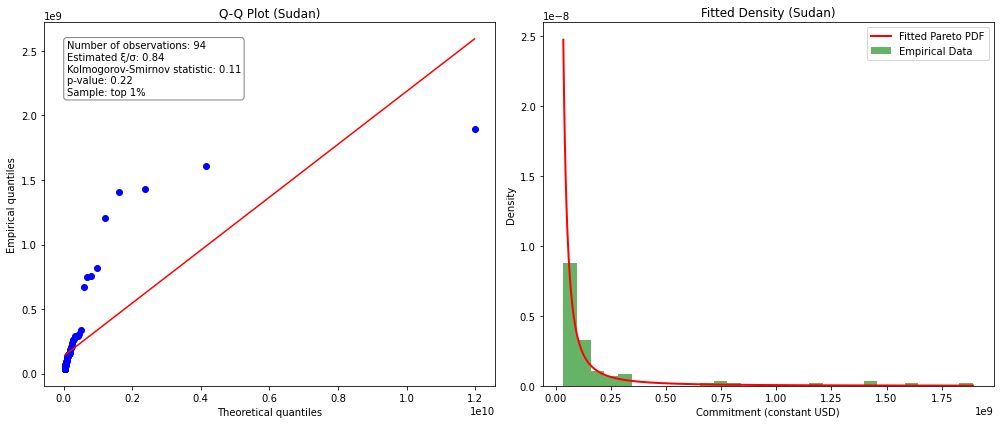

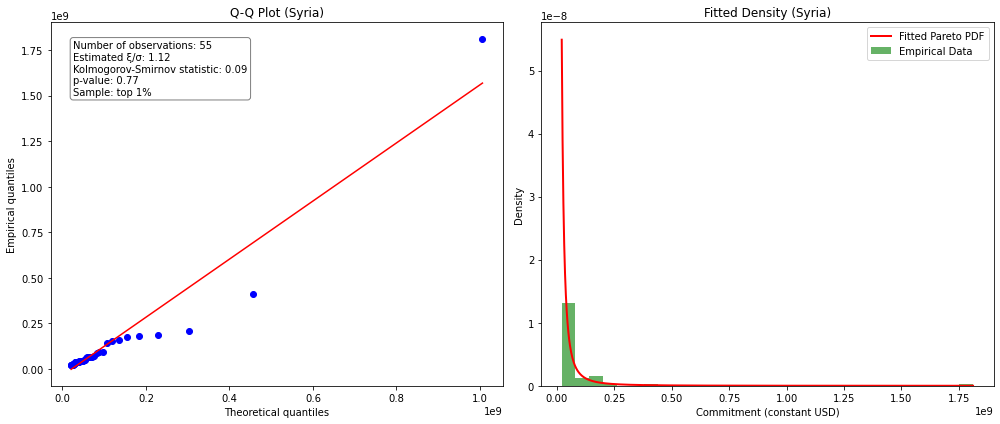

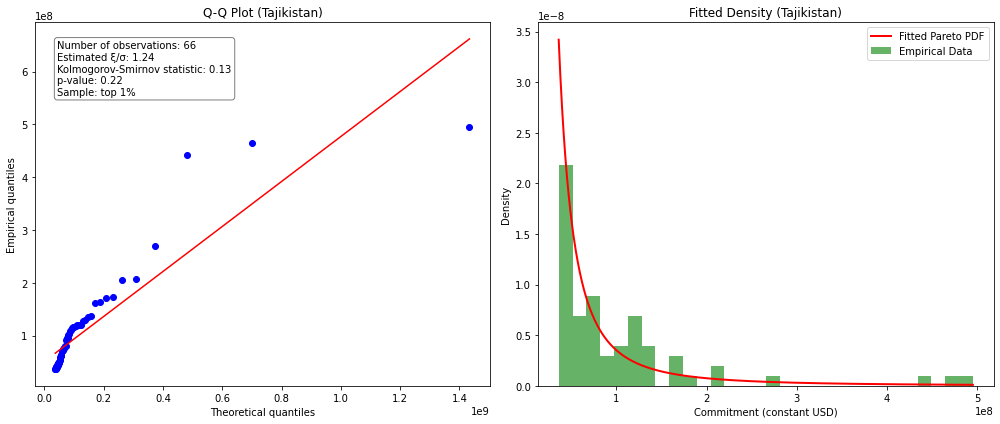

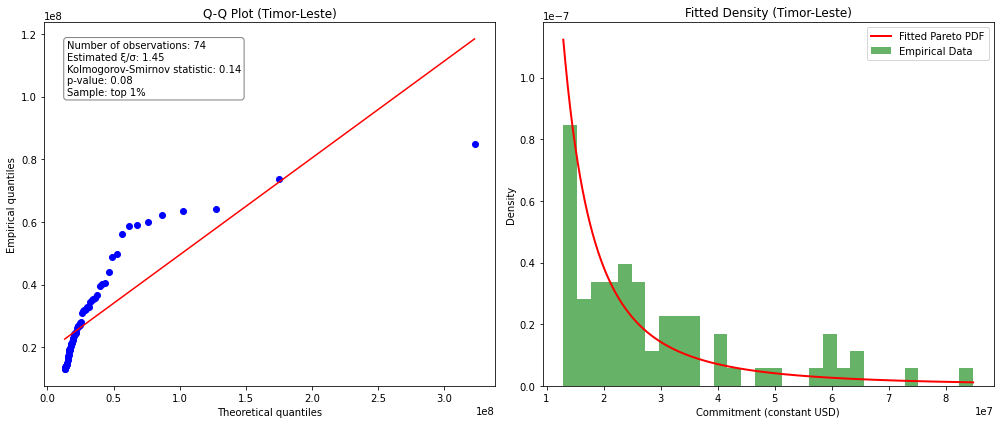

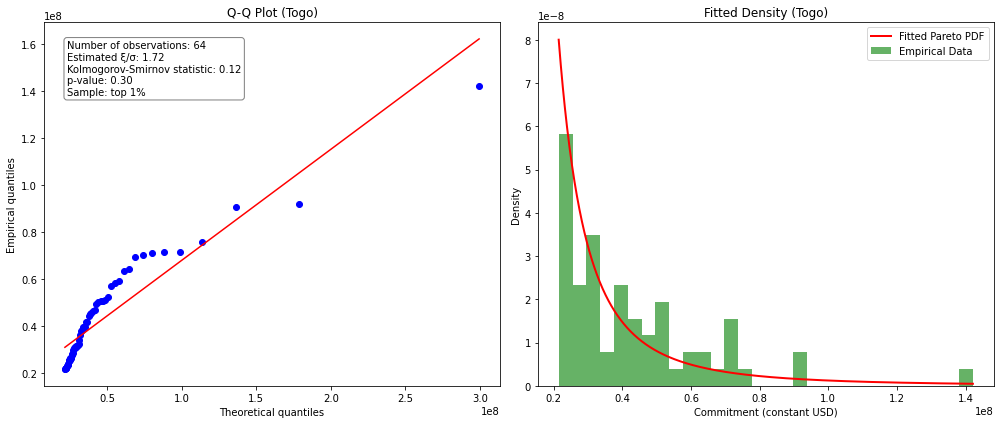

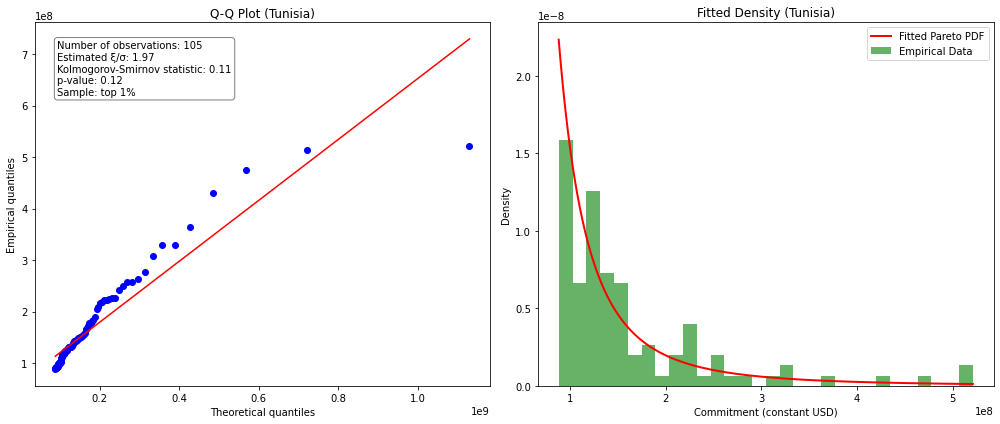

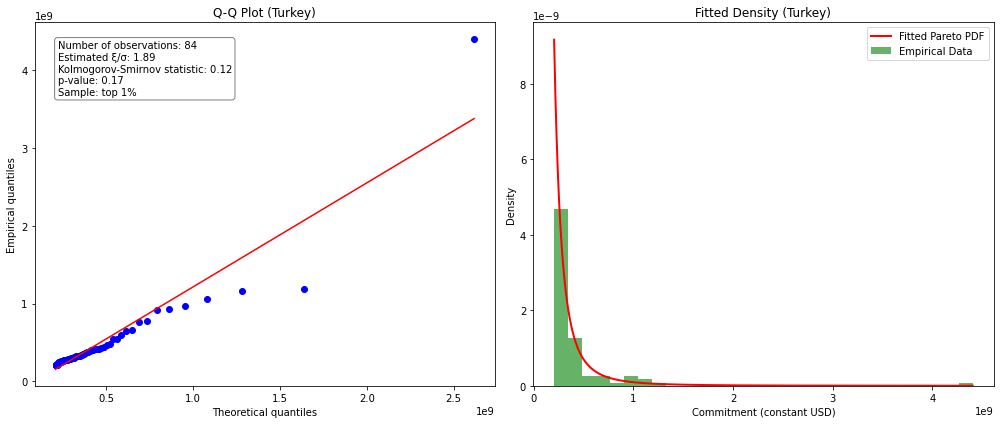

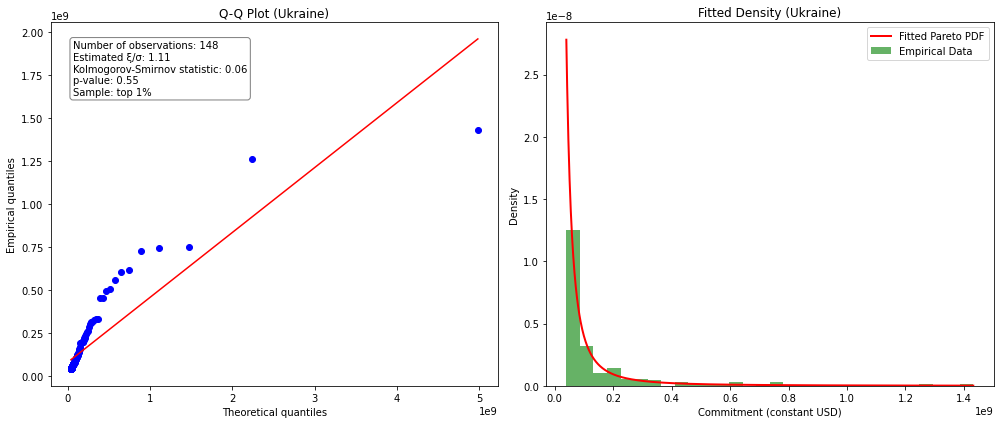

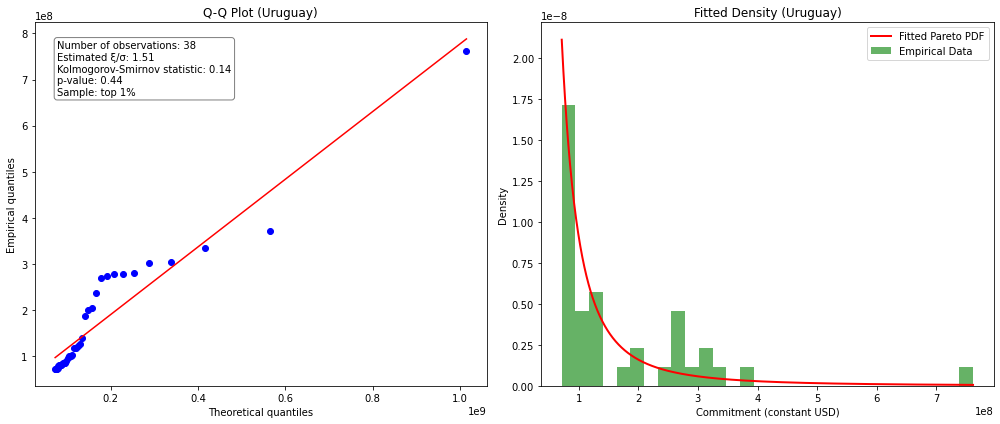

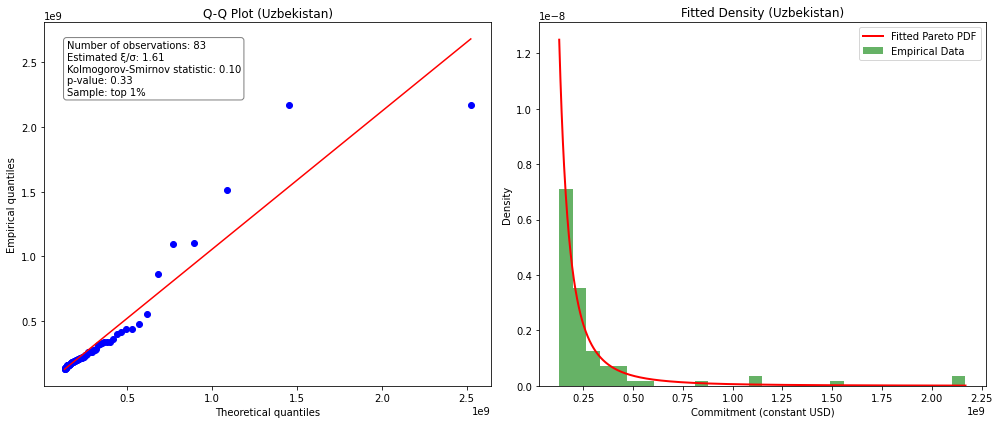

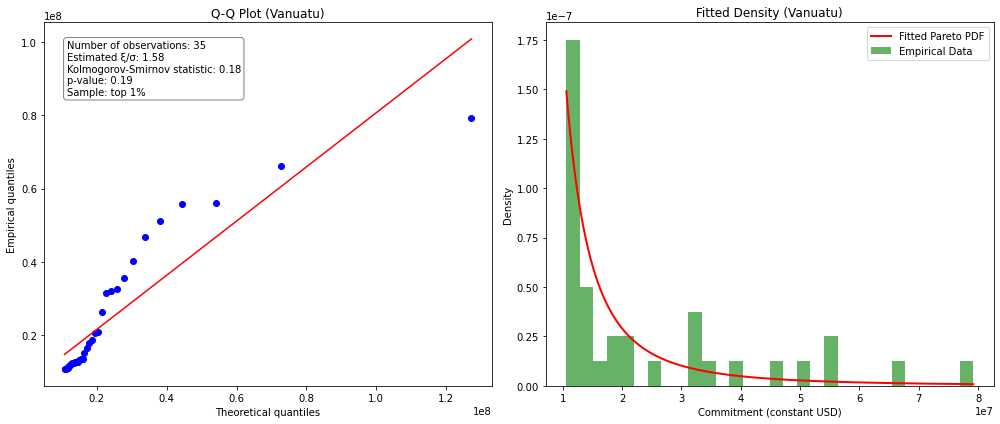

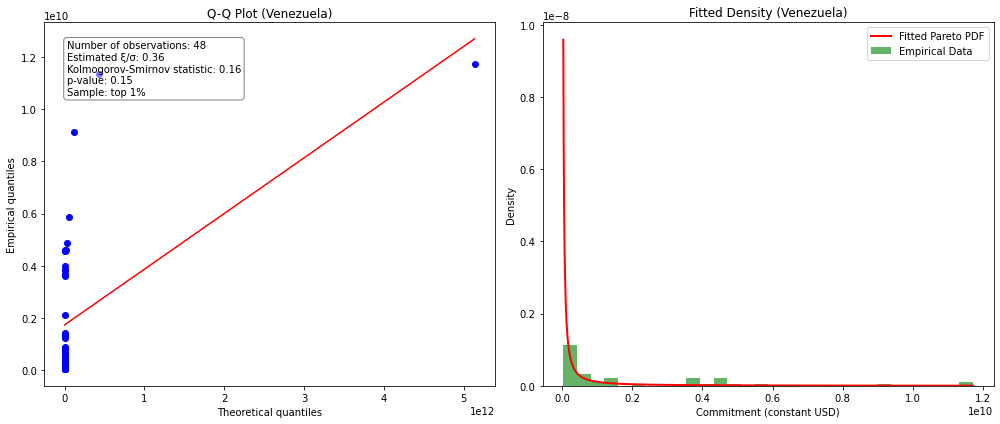

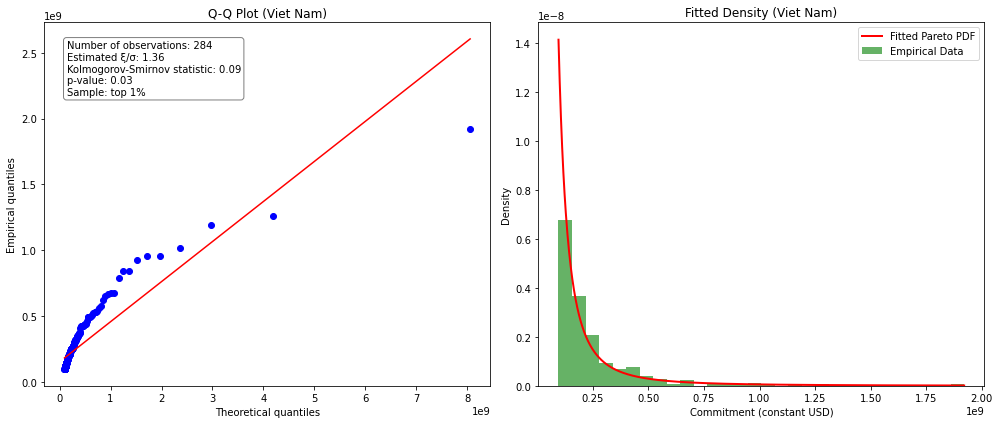

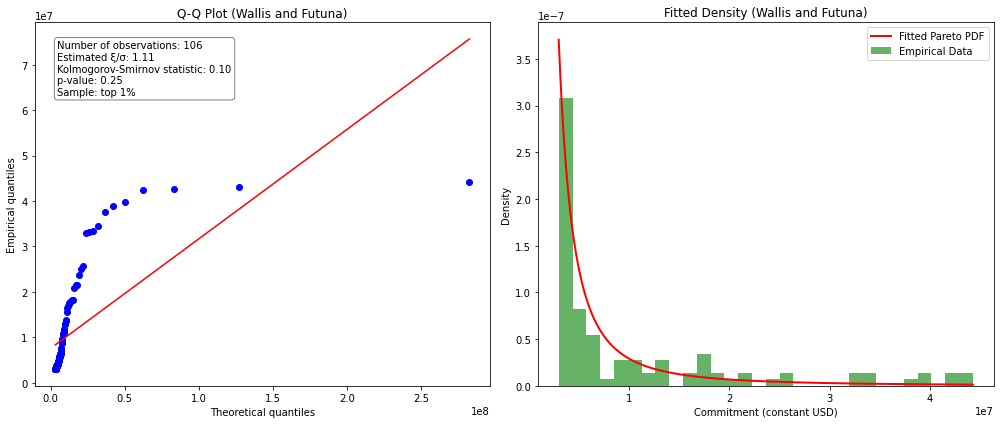

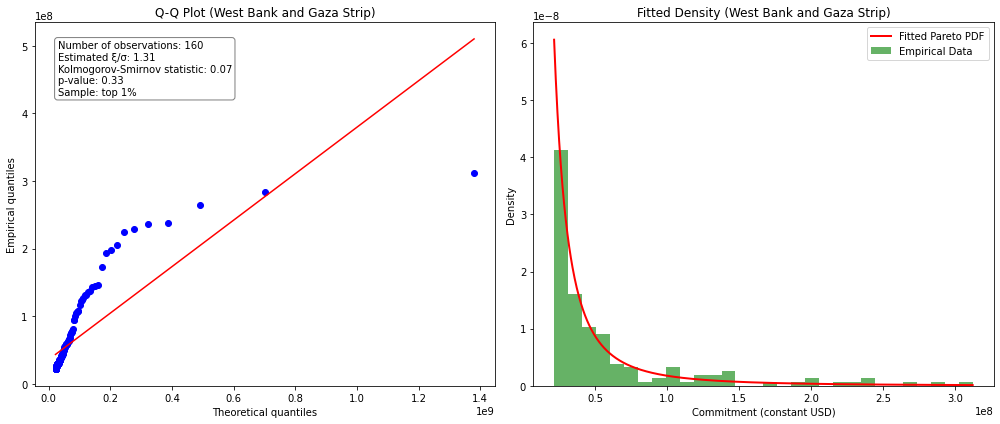

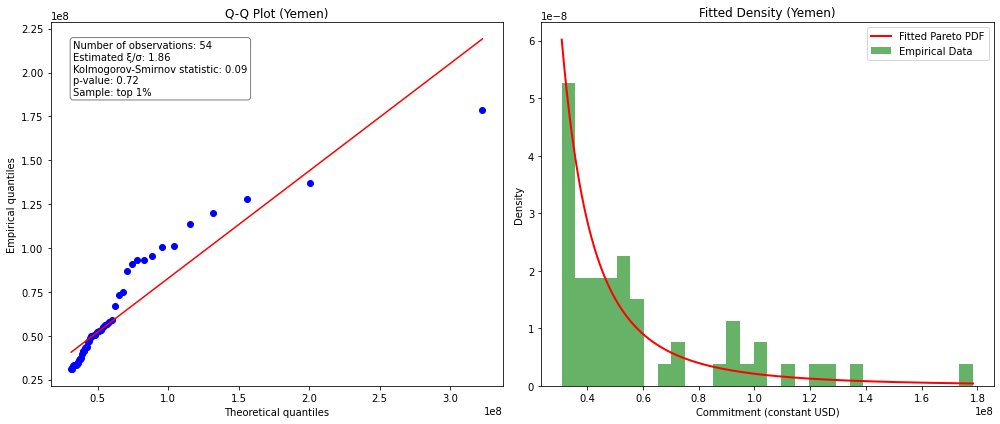

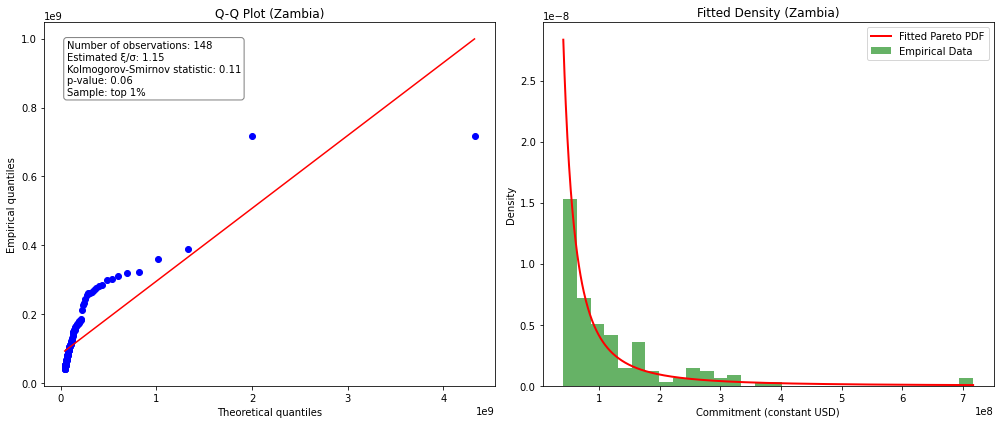

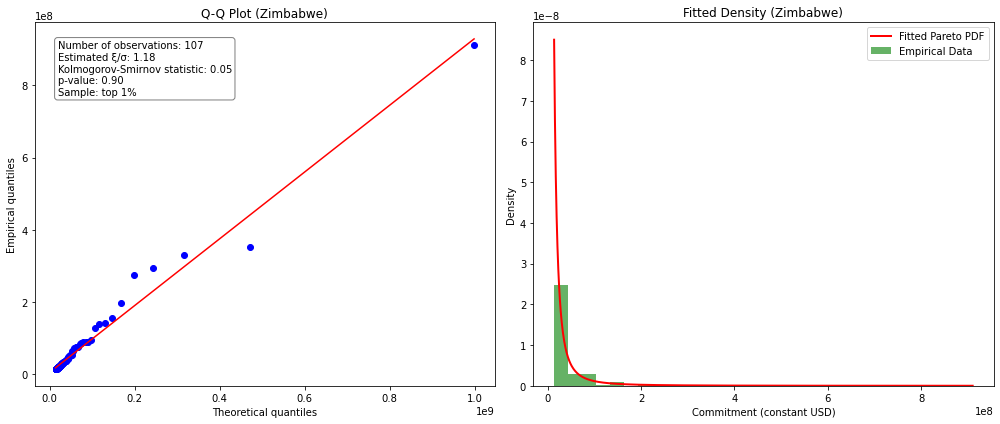

In [9]:
right_tail_results = []
for (recipient, iso_code), group in clean_data.groupby(['recipient', 'iso_code']):
    alpha, xm, percentile, num_observations, D, p_value = estimate_pareto_right_tail_with_gof(group['commitment_conusd'])
    if alpha is not None and xm is not None:
        right_tail_results.append({
            'recipient': recipient, 
            'alpha': alpha, 
            'xm': xm, 
            'percentile': percentile, 
            'num_observations': num_observations,
            'D': D,
            'p_value': p_value,
            'iso_code': iso_code
        })
        
        # Generate combined plot
        top_data = np.sort(group['commitment_conusd'])[::-1][:int(len(group) * percentile / 100)]
        title = f"{recipient}"
        combined_plot(top_data, alpha, xm, title, num_observations, D, p_value, percentile)

In [11]:
# Create a DataFrame to store the results
right_tail_results_df = pd.DataFrame(right_tail_results)

# Save the results to a CSV file
right_tail_results_df.to_csv('C:\\Users\\chans\\Desktop\\UpdatedEmpirics\\pareto_right_tail_results.csv', index=False)

print("Analysis complete. Results saved to 'pareto_right_tail_results.csv'")

Analysis complete. Results saved to 'pareto_right_tail_results.csv'


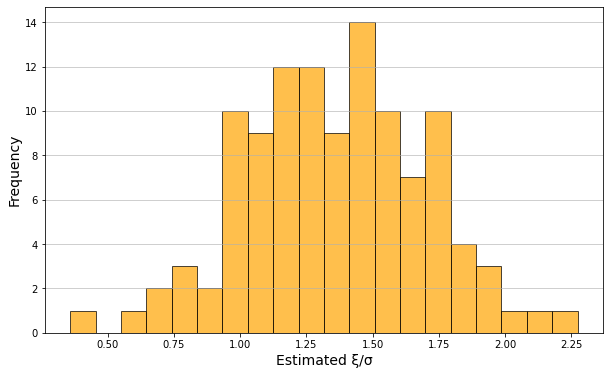

In [15]:
alpha_values = right_tail_results_df['alpha']

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(alpha_values, bins=20, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Estimated ξ/σ',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.75)

plt.show()